In [1]:
#!pip install pyLDAvis
#!pip install pandas wordcloud matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim import corpora


In [3]:

import pandas as pd
from google.colab import data_table
from google.colab import drive

dfNL = pd.read_parquet("inspections_recalls.parquet")


In [4]:
dfNL

FEINumber                                          LegalName  \
0            405                             Baxter Healthcare S.A.   
1           1196                                 Italfarmaco S.p.A.   
2           1379  Dynamit Nobel GmbH Explosivstoff- und Systemte...   
3        1010294                                     Old 97 Company   
4        1010370                                       USpharma Ltd   
...          ...                                                ...   
4216  3021451094  Purformance Wellness Pharmacy LLC dba Seven Cells   
4217  3021784212                         PRIME MATTER LABS WEST LLC   
4218  3021934346  Valor Compounding Pharmacy, Inc DBA  Valor Com...   
4219  3022352136                     BrittonField Laboratories Inc.   
4220  3023533273                     Sure-Biochem Laboratories, LLC   

                                       ShortDescription  \
0     Control procedures to monitor and validate per...   
1     Manufacturing Instructions and Specifications;...   
2     Investigations of discrepancies, failures; Wri...   
3     No written record of investigation; Scientific...   
4     Representative Samples; Establish reliability ...   
...                                                 ...   
4216  Non-microbial contamination, production area; ...   
4217  Calibration/Inspection/Checking not done; Inve...   
4218  Hazardous drugs, prevention of cross-contamina...   
4219  Test methods; Written procedures not establish...   
4220  Lack of quality control unit; Following/docume...   

                                        LongDescription  NAI  VAI  OAI  \
0     Control procedures are not established which m...    0    7    0   
1     The master production and control records are ...    0    4    0   
2     There is a failure to thoroughly review any un...    0    3    0   
3     Written records are not made of investigations...    0   21    0   
4     Representative samples are not taken of each s...    0    5    0   
...                                                 ...  ...  ...  ...   
4216  Non-microbial contamination was observed in yo...    0    2    0   
4217  Routine calibration of electronic equipment is...    0    3    0   
4218  You produced hazardous drugs without providing...    0    1    0   
4219  The accuracy, sensitivity, specificity and rep...    0    2    0   
4220  There is no quality control unit.; Established...    0    0    6   

      Injunction  Seizure  Warning Letter  RecallC1orC2  
0            0.0      0.0             0.0         False  
1            0.0      0.0             0.0         False  
2            0.0      0.0             0.0         False  
3            0.0      0.0             0.0         False  
4            0.0      0.0             0.0         False  
...          ...      ...             ...           ...  
4216         0.0      0.0             0.0         False  
4217         0.0      0.0             0.0         False  
4218         0.0      0.0             0.0          True  
4219         0.0      0.0             0.0         False  
4220         0.0      0.0             1.0         False  

[4221 rows x 11 columns]

In [5]:
from pandas.core.algorithms import value_counts
dfNL['Seizure'].value_counts()

Seizure
0.0    4210
1.0      11
Name: count, dtype: int64

In [6]:
# Create a function that calculates and displays
# the confusion matrix, accuracy, precision, recall, F1 score, and roc_auc_score

def display_metrics(y_test, y_pred, y_pred_prob):
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    class_report = classification_report(y_test, y_pred)
    print(class_report)
    # ROC curve
    from sklearn.metrics import roc_auc_score
    print("ROC_AUC: ", roc_auc_score(y_test, y_pred_prob))

# Draw a single ROC curve with a list of probability thresholds (default=[0.2,0.5, 0.8])
def draw_roc_curve(y_test, y_pred_prob, thresholds=[0.2,0.5, 0.8],
                   color='darkgreen',
                   show_thresholds=False,
                   classifier_name='Classifier'):

    from sklearn.metrics import roc_curve
    fpr, tpr, thr = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, color=color, marker='.', label=classifier_name)

    if not show_thresholds:
        thresholds=[] # An empty list to skip the for loop below
    # Add the threshold values to the plot
    for threshold in thresholds:
        # Find the closest threshold value
        close_idx = np.argmin(np.abs(thr - threshold))
        close_threshold = thr[close_idx]
        # Get the location of the threshold
        close_fpr = fpr[close_idx]
        close_tpr = tpr[close_idx]
        plt.plot(close_fpr, close_tpr, 'o', markersize=3)
        plt.text(close_fpr, close_tpr, round(close_threshold,2),
                 ha='right', va='bottom', color='red')

    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.show()

# Draw multiple ROC curves in a single plot with labels
def draw_roc_curves(y_test, prob_list, label_list):
    from sklearn.metrics import roc_curve
    for i in range(len(prob_list)):
        fpr, tpr, _ = roc_curve(y_test, prob_list[i])
        plt.plot(fpr,tpr,
                       color='C'+str(i),
                       marker='.',
                       label=label_list[i])
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.show()

# Short Description


In [7]:
# Removing punctuation.
# \w: Matches Unicode word characters
# \s: Matches Unicode whitespace characters
# There are several methods to do this, but we will focus on the most
# straightforward one. See:
# https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
simple_text_short = dfNL
simple_text_short['Cleaned Text'] = simple_text_short['ShortDescription'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)


# Verify punctuation is removed.
simple_text_short['Cleaned Text']

0       Control procedures to monitor and validate per...
1       Manufacturing Instructions and Specifications ...
2       Investigations of discrepancies failures Writt...
3       No written record of investigation Scientifica...
4       Representative Samples Establish reliability o...
                              ...                        
4216    Nonmicrobial contamination production area Haz...
4217    CalibrationInspectionChecking not done Investi...
4218     Hazardous drugs prevention of crosscontamination
4219    Test methods Written procedures not establishe...
4220    Lack of quality control unit Followingdocument...
Name: Cleaned Text, Length: 4221, dtype: object

In [8]:
# Stopword Removal
# https://www.analyticsvidhya.com/blog/2020/03/what-are-lambda-functions-in-python/
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

simple_text_short['Cleaned Text'] = simple_text_short['Cleaned Text'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

# Verify stop words are removed
simple_text_short['Cleaned Text']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0       Control procedures monitor validate performanc...
1       Manufacturing Instructions Specifications Stab...
2       Investigations discrepancies failures Written ...
3       No written record investigation Scientifically...
4       Representative Samples Establish reliability s...
                              ...                        
4216    Nonmicrobial contamination production area Haz...
4217    CalibrationInspectionChecking done Investigati...
4218        Hazardous drugs prevention crosscontamination
4219    Test methods Written procedures establishedfol...
4220    Lack quality control unit Followingdocumenting...
Name: Cleaned Text, Length: 4221, dtype: object

In [9]:
# Convert all words into lower cases
simple_text_short['Cleaned Text'] = simple_text_short['Cleaned Text'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

simple_text_short['Cleaned Text']

0       control procedures monitor validate performanc...
1       manufacturing instructions specifications stab...
2       investigations discrepancies failures written ...
3       no written record investigation scientifically...
4       representative samples establish reliability s...
                              ...                        
4216    nonmicrobial contamination production area haz...
4217    calibrationinspectionchecking done investigati...
4218        hazardous drugs prevention crosscontamination
4219    test methods written procedures establishedfol...
4220    lack quality control unit followingdocumenting...
Name: Cleaned Text, Length: 4221, dtype: object

In [10]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
simple_text_short['Cleaned Text'] = simple_text_short['Cleaned Text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
simple_text_short['Cleaned Text']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0       control procedure monitor validate performance...
1       manufacturing instruction specification stabil...
2       investigation discrepancy failure written proc...
3       no written record investigation scientifically...
4       representative sample establish reliability su...
                              ...                        
4216    nonmicrobial contamination production area haz...
4217    calibrationinspectionchecking done investigati...
4218         hazardous drug prevention crosscontamination
4219    test method written procedure establishedfollowed
4220    lack quality control unit followingdocumenting...
Name: Cleaned Text, Length: 4221, dtype: object

In [11]:
# Check DFM after further processing
docs_clean_short=simple_text_short['Cleaned Text']

corpus_clean_short = [doc.split() for doc in docs_clean_short]
dictionary_clean_short = corpora.Dictionary(corpus_clean_short)

DFM_clean_short = [dictionary_clean_short.doc2bow(doc) for doc in corpus_clean_short]

term_maps_short = dictionary_clean_short.token2id

term_maps_short = {v: k for k, v in term_maps_short.items()}

# compare this with the initial DFM
term_maps_short


{0: 'clean',
 1: 'complaint',
 2: 'control',
 3: 'discrepancy',
 4: 'documented',
 5: 'failure',
 6: 'followed',
 7: 'free',
 8: 'handling',
 9: 'infestation',
 10: 'investigation',
 11: 'laboratory',
 12: 'monitor',
 13: 'performance',
 14: 'procedure',
 15: 'sanitationbuildings',
 16: 'scientifically',
 17: 'sop',
 18: 'sound',
 19: 'validate',
 20: 'condition',
 21: 'described',
 22: 'fully',
 23: 'incomplete',
 24: 'instruction',
 25: 'manufacturing',
 26: 'record',
 27: 'sample',
 28: 'specification',
 29: 'stability',
 30: 'storage',
 31: 'writing',
 32: 'written',
 33: 'fail',
 34: 'include',
 35: 'actual',
 36: 'al',
 37: 'analysis',
 38: 'annual',
 39: 'area',
 40: 'batch',
 41: 'closure',
 42: 'complete',
 43: 'component',
 44: 'container',
 45: 'copy',
 46: 'cover',
 47: 'date',
 48: 'description',
 49: 'distribution',
 50: 'equipment',
 51: 'et',
 52: 'identification',
 53: 'inadequate',
 54: 'included',
 55: 'including',
 56: 'individual',
 57: 'information',
 58: 'inspect

In [12]:
DFM_clean_short

[[(0, 1),
  (1, 1),
  (2, 3),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 2),
  (14, 3),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 2)],
 [(6, 1),
  (10, 1),
  (14, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1)],
 [(3, 1),
  (5, 1),
  (6, 1),
  (10, 1),
  (14, 2),
  (22, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1)],
 [(2, 2),
  (4, 1),
  (6, 1),
  (10, 1),
  (11, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (24, 1),
  (25, 1),
  (26, 4),
  (28, 1),
  (29, 2),
  (32, 4),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 2),
  (63, 2),
  (64, 1),
  (65, 1),
  

In [13]:
myDFM_clean_short = pd.DataFrame(
    gensim.matutils.corpus2csc(DFM_clean_short).T.toarray()).rename(columns= term_maps_short)

myDFM_clean_short

clean  complaint  control  discrepancy  documented  failure  followed  \
0       1.0        1.0      3.0          1.0         1.0      1.0       1.0   
1       0.0        0.0      0.0          0.0         0.0      0.0       1.0   
2       0.0        0.0      0.0          1.0         0.0      1.0       1.0   
3       0.0        0.0      2.0          0.0         1.0      0.0       1.0   
4       0.0        0.0      0.0          1.0         0.0      1.0       0.0   
...     ...        ...      ...          ...         ...      ...       ...   
4216    0.0        0.0      0.0          0.0         0.0      0.0       0.0   
4217    0.0        0.0      0.0          1.0         0.0      1.0       0.0   
4218    0.0        0.0      0.0          0.0         0.0      0.0       0.0   
4219    0.0        0.0      0.0          0.0         0.0      0.0       0.0   
4220    0.0        0.0      4.0          0.0         0.0      0.0       0.0   

      free  handling  infestation  ...  benefit  board  dose  institutional  \
0      1.0       1.0          1.0  ...      0.0    0.0   0.0            0.0   
1      0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
2      0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
3      0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
4      0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
...    ...       ...          ...  ...      ...    ...   ...            ...   
4216   0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
4217   0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
4218   0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
4219   0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   
4220   0.0       0.0          0.0  ...      0.0    0.0   0.0            0.0   

      irb  knowledge  radiation  inactive  drain  sink  
0     0.0        0.0        0.0       0.0    0.0   0.0  
1     0.0        0.0        0.0       0.0    0.0   0.0  
2     0.0        0.0        0.0       0.0    0.0   0.0  
3     0.0        0.0        0.0       0.0    0.0   0.0  
4     0.0        0.0        0.0       0.0    0.0   0.0  
...   ...        ...        ...       ...    ...   ...  
4216  0.0        0.0        0.0       0.0    0.0   0.0  
4217  0.0        0.0        0.0       0.0    0.0   0.0  
4218  0.0        0.0        0.0       0.0    0.0   0.0  
4219  0.0        0.0        0.0       0.0    0.0   0.0  
4220  0.0        0.0        0.0       0.0    0.0   0.0  

[4221 rows x 728 columns]

In [14]:
# Create a function to check the number of features/terms in the potential DFM.
# # set: unordered collection of unique items

text_series = simple_text_short['Cleaned Text'] # Create a deep copy

def dim():
    global text_series
    dimensions = len(set(text_series.str.split().explode().values))
    # same result:
    # dimensions = len(text_series.str.split().explode().unique())
    print(f'{dimensions} dimensions in the potential DFM.')


# Create a function display top N words and frequency
def top_words(n=20):
    global text_series
    freq = text_series.str.split().explode().value_counts()[:n]
    print(f'Top {n} words:\n{freq}')

dim()
top_words()

728 dimensions in the potential DFM.
Top 20 words:
Cleaned Text
procedure        9274
written          6484
control          4604
followed         3704
record           3359
writing          2138
drug             2023
investigation    2018
testing          1843
fully            1816
product          1811
failure          1700
laboratory       1675
discrepancy      1404
component        1336
review           1319
batch            1228
test             1201
program          1133
sound            1115
Name: count, dtype: int64


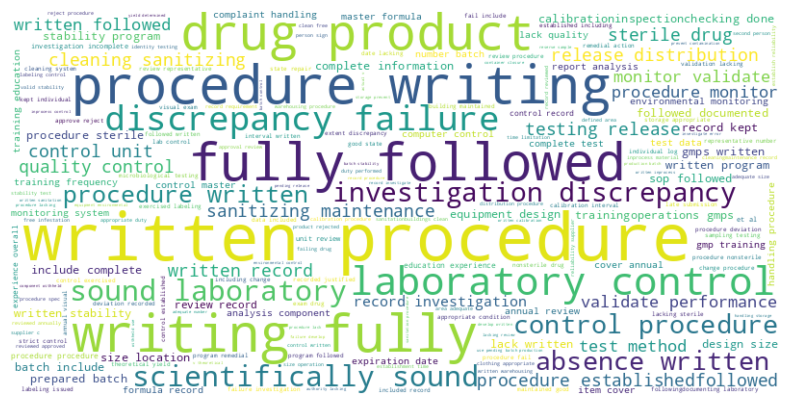

In [15]:

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# DataFrame

# Combine all text data into a single string
text_short = " ".join(simple_text_short['Cleaned Text'])

# Create the WordCloud object
wordcloud_short = WordCloud(width=800, height=400, background_color='white').generate(text_short)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_short, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
doc_complete_short = docs_clean_short


In [17]:
# Tokenize each document
corpus_S = [doc.split() for doc in doc_complete_short]
print(type(corpus_S), type(corpus_S[0]), type(corpus_S[0][0]))
print(len(corpus_S[0]))
print(corpus_S[0][:10])

<class 'list'> <class 'list'> <class 'str'>
27
['control', 'procedure', 'monitor', 'validate', 'performance', 'scientifically', 'sound', 'laboratory', 'control', 'investigation']


In [18]:
# https://radimrehurek.com/gensim/index.html
# import gensim
from gensim import corpora, models
# Create the term dictionary of our courpus, where every unique term is assigned an index.
dictionary_S = corpora.Dictionary(corpus_S)
# Filter out extreme tokens
# Less than no_below documents (absolute number)
# More than no_above documents (fraction of total corpus size, not absolute number)
dictionary_S.filter_extremes(no_below=2, no_above=0.75)
# Converting list of documents (corpus) into Document Term Matrix
# using dictionary prepared above.
DFM_S = [dictionary_S.doc2bow(doc) for doc in corpus_S]
# Frequency of individual words in each document: not very human readable
# print(DFM)
# Number of documents
print(len(DFM_S))
print(dictionary_S.token2id)
# Number of terms
print(len(dictionary_S.token2id))

4221
{'clean': 0, 'complaint': 1, 'control': 2, 'discrepancy': 3, 'documented': 4, 'failure': 5, 'followed': 6, 'free': 7, 'handling': 8, 'infestation': 9, 'investigation': 10, 'laboratory': 11, 'monitor': 12, 'performance': 13, 'procedure': 14, 'sanitationbuildings': 15, 'scientifically': 16, 'sop': 17, 'sound': 18, 'validate': 19, 'condition': 20, 'described': 21, 'fully': 22, 'incomplete': 23, 'instruction': 24, 'manufacturing': 25, 'record': 26, 'sample': 27, 'specification': 28, 'stability': 29, 'storage': 30, 'writing': 31, 'written': 32, 'fail': 33, 'include': 34, 'actual': 35, 'al': 36, 'analysis': 37, 'annual': 38, 'area': 39, 'batch': 40, 'closure': 41, 'complete': 42, 'component': 43, 'container': 44, 'copy': 45, 'cover': 46, 'date': 47, 'description': 48, 'distribution': 49, 'equipment': 50, 'et': 51, 'identification': 52, 'inadequate': 53, 'included': 54, 'including': 55, 'individual': 56, 'information': 57, 'inspection': 58, 'item': 59, 'kept': 60, 'label': 61, 'labeling'

In [19]:
# Use the word embedding model to identify similar words
# https://radimrehurek.com/gensim/models/word2vec.html
# https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-597
# size: The number of dimensions of the embeddings and the default is 100.
# window: The maximum distance between a target word and words around the target word. # The default window is 5.
# min_count: The minimum count of words to consider when training the model;
# words with occurrence less than this count will be ignored. The default is 5.
# workers: The number of partitions during training and the default workers is 3. # sg: The training algorithm, either CBOW(0) or skip gram(1).
# The default training algorithm is CBOW.
from gensim.models import Word2Vec
model_S = Word2Vec(corpus_S, min_count=20,workers=3, window =3, sg = 1)
# Most similar words to"
display(model_S.wv.most_similar('procedure',topn=5))

[('warehousing', 0.550940215587616),
 ('responsibility', 0.5198234915733337),
 ('detail', 0.5177087783813477),
 ('following', 0.49591535329818726),
 ('written', 0.495383620262146)]

In [20]:
display(model_S.wv.most_similar('control',topn=5))

[('issued', 0.5302814841270447),
 ('scientifically', 0.47244128584861755),
 ('destruction', 0.4719456732273102),
 ('laboratory', 0.4559355676174164),
 ('exercised', 0.45166534185409546)]

In [21]:
# Create a LDA model using gensim library
# https://radimrehurek.com/gensim/models/ldamodel.html
n_topics = 3
ldamodel_S = models.LdaModel(DFM_S, num_topics=n_topics,id2word = dictionary_S, passes=40)
ldamodel_S.print_topics(num_topics=n_topics, num_words=10)

[(0,
  '0.084*"procedure" + 0.070*"written" + 0.032*"followed" + 0.032*"control" + 0.025*"record" + 0.022*"batch" + 0.021*"testing" + 0.020*"writing" + 0.018*"component" + 0.016*"lack"'),
 (1,
  '0.069*"procedure" + 0.053*"control" + 0.034*"investigation" + 0.032*"record" + 0.031*"written" + 0.031*"failure" + 0.030*"laboratory" + 0.029*"followed" + 0.024*"discrepancy" + 0.022*"test"'),
 (2,
  '0.062*"drug" + 0.056*"product" + 0.047*"sterile" + 0.046*"area" + 0.044*"system" + 0.030*"lacking" + 0.025*"cleaning" + 0.025*"environmental" + 0.020*"contamination" + 0.020*"monitoring"')]

In [22]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models
vis_S = pyLDAvis.gensim_models.prepare(ldamodel_S, DFM_S, dictionary_S)
vis_S


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.144124 -0.135200       1        1  48.601390
1     -0.162793  0.129827       2        1  39.370651
2      0.306916  0.005374       3        1  12.027958, topic_info=             Term         Freq        Total Category  logprob  loglift
108          drug  2010.000000  2010.000000  Default  30.0000  30.0000
159       product  1744.000000  1744.000000  Default  29.0000  29.0000
170       sterile   744.000000   744.000000  Default  28.0000  28.0000
39           area   736.000000   736.000000  Default  27.0000  27.0000
254        system   692.000000   692.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
74        release   139.827239   955.954191   Topic3  -4.7295   0.1956
73        program   128.367236  1109.220533   Topic3  -4.8150  -0.0386
49   distribution   127.977078  1003.439148   Topic3  -4.8180   0.0586
14      procedure   130.796911  9048.925296   Topic3  -4.7963  -2.1188
32        written   127.190923  6222.494119   Topic3  -4.8242  -1.7723

[210 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
151       2  0.994117    15day
307       1  0.987560        2
541       3  0.995281        5
100       1  0.754641  absence
100       2  0.219864  absence
...     ...       ...      ...
32        1  0.718361  written
32        2  0.261310  written
32        3  0.020410  written
84        1  0.983026    yield
84        2  0.018204    yield

[272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

Long Descripton Processing

# Long Description

In [23]:
# Removing punctuation.
# \w: Matches Unicode word characters
# \s: Matches Unicode whitespace characters
# There are several methods to do this, but we will focus on the most
# straightforward one. See:
# https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
simple_text_long = dfNL
simple_text_long['Cleaned Text Long'] = simple_text_long['LongDescription'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)


# Verify punctuation is removed.
simple_text_long['Cleaned Text Long']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       Control procedures are not established which m...
1       The master production and control records are ...
2       There is a failure to thoroughly review any un...
3       Written records are not made of investigations...
4       Representative samples are not taken of each s...
                              ...                        
4216    Nonmicrobial contamination was observed in you...
4217    Routine calibration of electronic equipment is...
4218    You produced hazardous drugs without providing...
4219    The accuracy sensitivity specificity and repro...
4220    There is no quality control unit Established l...
Name: Cleaned Text Long, Length: 4221, dtype: object

In [24]:
# Stopword Removal

simple_text_long['Cleaned Text Long'] = simple_text_long['Cleaned Text Long'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

# Verify stop words are removed
simple_text_long['Cleaned Text Long']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       Control procedures established monitor output ...
1       The master production control records deficien...
2       There failure thoroughly review unexplained di...
3       Written records made investigations failure ba...
4       Representative samples taken shipment lot comp...
                              ...                        
4216    Nonmicrobial contamination observed production...
4217    Routine calibration electronic equipment perfo...
4218    You produced hazardous drugs without providing...
4219    The accuracy sensitivity specificity reproduci...
4220    There quality control unit Established laborat...
Name: Cleaned Text Long, Length: 4221, dtype: object

In [25]:
# Convert all words into lower cases
simple_text_long['Cleaned Text Long'] = simple_text_long['Cleaned Text Long'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

simple_text_long['Cleaned Text Long']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       control procedures established monitor output ...
1       the master production control records deficien...
2       there failure thoroughly review unexplained di...
3       written records made investigations failure ba...
4       representative samples taken shipment lot comp...
                              ...                        
4216    nonmicrobial contamination observed production...
4217    routine calibration electronic equipment perfo...
4218    you produced hazardous drugs without providing...
4219    the accuracy sensitivity specificity reproduci...
4220    there quality control unit established laborat...
Name: Cleaned Text Long, Length: 4221, dtype: object

In [26]:
# Lemmatization
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
simple_text_long['Cleaned Text Long']=simple_text_long['Cleaned Text Long'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# Check DFM after further processing
docs_clean_long=simple_text_long['Cleaned Text Long']

corpus_clean_long = [doc.split() for doc in docs_clean_long]
dictionary_clean_long = corpora.Dictionary(corpus_clean_long)

DFM_clean_long = [dictionary_clean_long.doc2bow(doc) for doc in corpus_clean_long]

term_maps_long = dictionary_clean_long.token2id

term_maps_long = {v: k for k, v in term_maps_long.items()}

# compare this with the initial DFM
term_maps_long


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: 'already',
 1: 'appropriate',
 2: 'assure',
 3: 'batch',
 4: 'building',
 5: 'causing',
 6: 'characteristic',
 7: 'clean',
 8: 'complaint',
 9: 'component',
 10: 'condition',
 11: 'conform',
 12: 'control',
 13: 'deficiently',
 14: 'describing',
 15: 'designed',
 16: 'discrepancy',
 17: 'distributed',
 18: 'documented',
 19: 'drug',
 20: 'established',
 21: 'establishment',
 22: 'failure',
 23: 'followed',
 24: 'handling',
 25: 'holding',
 26: 'identity',
 27: 'include',
 28: 'inprocess',
 29: 'laboratory',
 30: 'maintained',
 31: 'manufacture',
 32: 'manufacturing',
 33: 'material',
 34: 'may',
 35: 'meet',
 36: 'monitor',
 37: 'oral',
 38: 'output',
 39: 'packing',
 40: 'performance',
 41: 'procedure',
 42: 'process',
 43: 'processing',
 44: 'product',
 45: 'production',
 46: 'purity',
 47: 'quality',
 48: 'related',
 49: 'responsible',
 50: 'review',
 51: 'sanitary',
 52: 'scientifically',
 53: 'sound',
 54: 'specification',
 55: 'standard',
 56: 'strength',
 57: 'test',
 58: 't

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
DFM_clean_long

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 2),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 4),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 2),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 3),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 3),
  (34, 2),
  (35, 1),
  (36, 2),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 1),
  (41, 5),
  (42, 3),
  (43, 1),
  (44, 4),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 3)],
 [(10, 1),
  (12, 2),
  (16, 1),
  (19, 1),
  (23, 1),
  (27, 2),
  (41, 2),
  (44, 1),
  (45, 1),
  (47, 1),
  (61, 1),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1

In [29]:
myDFM_clean_long = pd.DataFrame(
    gensim.matutils.corpus2csc(DFM_clean_long).T.toarray()).rename(columns= term_maps_long)

myDFM_clean_long

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


already  appropriate  assure  batch  building  causing  characteristic  \
0         1.0          2.0     1.0    2.0       1.0      2.0             2.0   
1         0.0          0.0     0.0    0.0       0.0      0.0             0.0   
2         1.0          0.0     0.0    2.0       0.0      0.0             0.0   
3         0.0          5.0     1.0   17.0       0.0      0.0             2.0   
4         1.0          1.0     0.0    1.0       0.0      0.0             0.0   
...       ...          ...     ...    ...       ...      ...             ...   
4216      0.0          0.0     0.0    0.0       0.0      0.0             0.0   
4217      1.0          1.0     1.0    2.0       0.0      0.0             0.0   
4218      0.0          0.0     0.0    0.0       0.0      0.0             0.0   
4219      0.0          0.0     0.0    0.0       0.0      0.0             0.0   
4220      0.0          2.0     2.0    0.0       0.0      0.0             0.0   

      clean  complaint  component  ...  likely  organ  radiation  whole  \
0       1.0        1.0        1.0  ...     0.0    0.0        0.0    0.0   
1       0.0        0.0        0.0  ...     0.0    0.0        0.0    0.0   
2       0.0        0.0        1.0  ...     0.0    0.0        0.0    0.0   
3       0.0        1.0        4.0  ...     0.0    0.0        0.0    0.0   
4       0.0        0.0        2.0  ...     0.0    0.0        0.0    0.0   
...     ...        ...        ...  ...     ...    ...        ...    ...   
4216    0.0        0.0        0.0  ...     0.0    0.0        0.0    0.0   
4217    0.0        0.0        2.0  ...     0.0    0.0        0.0    0.0   
4218    0.0        0.0        0.0  ...     0.0    0.0        0.0    0.0   
4219    0.0        0.0        0.0  ...     0.0    0.0        0.0    0.0   
4220    0.0        0.0        1.0  ...     0.0    0.0        0.0    0.0   

      equipmentsupplies  placed  pharmaceutical  inactive  sink  wrist  
0                   0.0     0.0             0.0       0.0   0.0    0.0  
1                   0.0     0.0             0.0       0.0   0.0    0.0  
2                   0.0     0.0             0.0       0.0   0.0    0.0  
3                   0.0     0.0             0.0       0.0   0.0    0.0  
4                   0.0     0.0             0.0       0.0   0.0    0.0  
...                 ...     ...             ...       ...   ...    ...  
4216                0.0     0.0             0.0       0.0   0.0    0.0  
4217                0.0     0.0             0.0       0.0   0.0    0.0  
4218                0.0     0.0             0.0       0.0   0.0    0.0  
4219                0.0     0.0             0.0       0.0   0.0    0.0  
4220                0.0     0.0             0.0       0.0   0.0    0.0  

[4221 rows x 1306 columns]

In [30]:
# Create a function to check the number of features/terms in the potential DFM.
# # set: unordered collection of unique items

text_series2 = simple_text_long['Cleaned Text Long'] # Create a deep copy

def dim2():
    global text_series2
    dimensions2 = len(set(text_series2.str.split().explode().values))
    # same result:
    # dimensions = len(text_series2.str.split().explode().unique())
    print(f'{dimensions2} dimensions in the potential DFM.')


# Create a function display top N words and frequency
def top_words2(n=20):
    global text_series2
    freq2 = text_series2.str.split().explode().value_counts()[:n]
    print(f'Top {n} words:\n{freq2}')

dim2()
top_words2()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1306 dimensions in the potential DFM.
Top 20 words:
Cleaned Text Long
drug           18526
product        17890
control        13457
procedure      12933
written        11339
appropriate     8555
quality         8408
batch           7344
record          7263
production      5987
include         5797
the             5434
identity        5217
followed        4968
assure          4905
established     4898
component       4881
equipment       4773
designed        4640
strength        4536
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


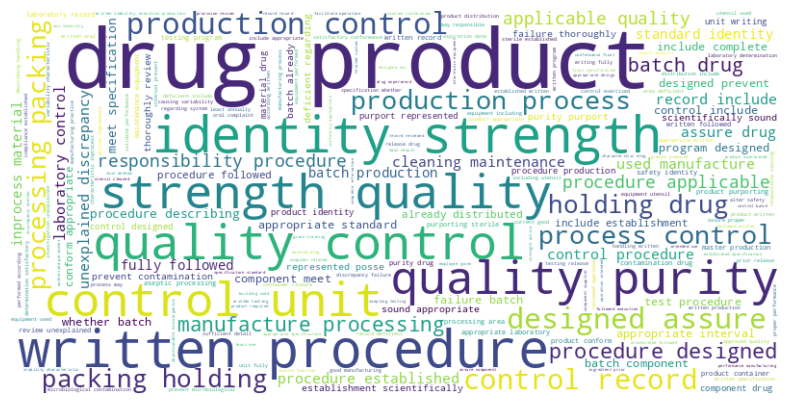

In [31]:

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# DataFrame

# Combine all text data into a single string
text = " ".join(simple_text_long['Cleaned Text Long'])

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
doc_complete_long = docs_clean_long


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Tokenize each document
corpus_L = [doc.split() for doc in doc_complete_long]
print(type(corpus_L), type(corpus_L[0]), type(corpus_L[0][0]))
print(len(corpus_L[0]))
print(corpus_L[0][:10])

<class 'list'> <class 'list'> <class 'str'>
99
['control', 'procedure', 'established', 'monitor', 'output', 'manufacturing', 'process', 'may', 'responsible', 'causing']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# https://radimrehurek.com/gensim/index.html
# import gensim
from gensim import corpora, models
# Create the term dictionary of our courpus, where every unique term is assigned an index.
dictionary_L = corpora.Dictionary(corpus_L)
# Filter out extreme tokens
# Less than no_below documents (absolute number)
# More than no_above documents (fraction of total corpus size, not absolute number)
dictionary_L.filter_extremes(no_below=2, no_above=0.75)
# Converting list of documents (corpus) into Document Term Matrix
# using dictionary prepared above.
DFM_L = [dictionary_L.doc2bow(doc) for doc in corpus_L]
# Frequency of individual words in each document: not very human readable
# print(DFM)
# Number of documents
print(len(DFM_L))
print(dictionary_L.token2id)
# Number of terms
print(len(dictionary_L.token2id))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4221
{'already': 0, 'appropriate': 1, 'assure': 2, 'batch': 3, 'building': 4, 'causing': 5, 'characteristic': 6, 'clean': 7, 'complaint': 8, 'component': 9, 'condition': 10, 'conform': 11, 'deficiently': 12, 'describing': 13, 'designed': 14, 'discrepancy': 15, 'distributed': 16, 'documented': 17, 'established': 18, 'establishment': 19, 'failure': 20, 'followed': 21, 'handling': 22, 'holding': 23, 'identity': 24, 'include': 25, 'inprocess': 26, 'laboratory': 27, 'maintained': 28, 'manufacture': 29, 'manufacturing': 30, 'material': 31, 'may': 32, 'meet': 33, 'monitor': 34, 'oral': 35, 'output': 36, 'packing': 37, 'performance': 38, 'process': 39, 'processing': 40, 'production': 41, 'purity': 42, 'quality': 43, 'related': 44, 'responsible': 45, 'review': 46, 'sanitary': 47, 'scientifically': 48, 'sound': 49, 'specification': 50, 'standard': 51, 'strength': 52, 'test': 53, 'there': 54, 'thoroughly': 55, 'time': 56, 'unexplained': 57, 'used': 58, 'variability': 59, 'whether': 60, 'always': 

In [35]:
# Use the word embedding model to identify similar words
# https://radimrehurek.com/gensim/models/word2vec.html
# https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-597
# size: The number of dimensions of the embeddings and the default is 100.
# window: The maximum distance between a target word and words around the target word. # The default window is 5.
# min_count: The minimum count of words to consider when training the model;
# words with occurrence less than this count will be ignored. The default is 5.
# workers: The number of partitions during training and the default workers is 3. # sg: The training algorithm, either CBOW(0) or skip gram(1).
# The default training algorithm is CBOW.
from gensim.models import Word2Vec
model_L = Word2Vec(corpus_L, min_count=20,workers=3, window =3, sg = 1)
# Most similar words to"



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
display(model_L.wv.most_similar('procedure',topn=5))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('plan', 0.4487634003162384),
 ('assignment', 0.41616129875183105),
 ('deviation', 0.4108498990535736),
 ('written', 0.39975810050964355),
 ('control', 0.38937440514564514)]

In [37]:
display(model_L.wv.most_similar('control',topn=5))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('thereto', 0.4848371744155884),
 ('production', 0.4708012342453003),
 ('drafted', 0.46589046716690063),
 ('investigate', 0.4265815019607544),
 ('specified', 0.4151924252510071)]

In [38]:
# Create a LDA model using gensim library
# https://radimrehurek.com/gensim/models/ldamodel.html
ldamodel_L = models.LdaModel(DFM_L, num_topics=n_topics,id2word = dictionary_L, passes=40)
ldamodel_L.print_topics(num_topics=n_topics, num_words=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.040*"aseptic" + 0.040*"area" + 0.038*"processing" + 0.033*"contamination" + 0.033*"prevent" + 0.029*"deficient" + 0.024*"regarding" + 0.023*"sterile" + 0.019*"system" + 0.019*"purporting"'),
 (1,
  '0.026*"quality" + 0.025*"appropriate" + 0.022*"record" + 0.021*"batch" + 0.018*"production" + 0.017*"include" + 0.017*"identity" + 0.016*"the" + 0.015*"assure" + 0.014*"established"'),
 (2,
  '0.045*"report" + 0.042*"supplier" + 0.032*"analysis" + 0.029*"experience" + 0.026*"adverse" + 0.018*"reliability" + 0.018*"within" + 0.017*"fda" + 0.016*"the" + 0.016*"result"')]

In [39]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models
vis_L = pyLDAvis.gensim_models.prepare(ldamodel_L, DFM_L, dictionary_L)
vis_L

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.096000  0.190346       1        1  83.739333
0     -0.235639 -0.143491       2        1   9.769948
2      0.331639 -0.046855       3        1   6.490719, topic_info=              Term         Freq        Total Category  logprob  loglift
40      processing  3637.000000  3637.000000  Default  30.0000  30.0000
243        prevent  2415.000000  2415.000000  Default  29.0000  29.0000
65       deficient  2716.000000  2716.000000  Default  28.0000  28.0000
218  contamination  2222.000000  2222.000000  Default  27.0000  27.0000
14        designed  4682.000000  4682.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
83             the   406.234119  5722.316816   Topic3  -4.1139   0.0896
444     validation   220.231265   593.242482   Topic3  -4.7262   1.7439
16     distributed   258.036072  1560.247763   Topic3  -4.5678   0.9353
107           date   235.250451  1023.165274   Topic3  -4.6602   1.2648
172       interval   230.505312  1459.293756   Topic3  -4.6806   0.8894

[201 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
295       3  0.991448        15
986       2  0.958655         5
986       3  0.035319         5
787       3  0.995504        60
92        3  0.998477  accepted
...     ...       ...       ...
167       2  0.339303   without
167       3  0.659871   without
857       2  0.991719      work
797       2  0.817877       you
797       3  0.180794       you

[276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

# Model 1 Logistic Regression

In [40]:
M1 = dfNL.copy()
M1.drop("Cleaned Text", inplace=True, axis='columns')
M1.drop("Cleaned Text Long", inplace=True, axis='columns')
M1.drop("ShortDescription", inplace=True, axis='columns')
M1.drop("LongDescription", inplace=True, axis='columns')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
M1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FEINumber                                          LegalName  NAI  VAI  \
0            405                             Baxter Healthcare S.A.    0    7   
1           1196                                 Italfarmaco S.p.A.    0    4   
2           1379  Dynamit Nobel GmbH Explosivstoff- und Systemte...    0    3   
3        1010294                                     Old 97 Company    0   21   
4        1010370                                       USpharma Ltd    0    5   
...          ...                                                ...  ...  ...   
4216  3021451094  Purformance Wellness Pharmacy LLC dba Seven Cells    0    2   
4217  3021784212                         PRIME MATTER LABS WEST LLC    0    3   
4218  3021934346  Valor Compounding Pharmacy, Inc DBA  Valor Com...    0    1   
4219  3022352136                     BrittonField Laboratories Inc.    0    2   
4220  3023533273                     Sure-Biochem Laboratories, LLC    0    0   

      OAI  Injunction  Seizure  Warning Letter  RecallC1orC2  
0       0         0.0      0.0             0.0         False  
1       0         0.0      0.0             0.0         False  
2       0         0.0      0.0             0.0         False  
3       0         0.0      0.0             0.0         False  
4       0         0.0      0.0             0.0         False  
...   ...         ...      ...             ...           ...  
4216    0         0.0      0.0             0.0         False  
4217    0         0.0      0.0             0.0         False  
4218    0         0.0      0.0             0.0          True  
4219    0         0.0      0.0             0.0         False  
4220    6         0.0      0.0             1.0         False  

[4221 rows x 9 columns]

In [42]:
M1.info()
M1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FEINumber       4221 non-null   int64  
 1   LegalName       4221 non-null   object 
 2   NAI             4221 non-null   int64  
 3   VAI             4221 non-null   int64  
 4   OAI             4221 non-null   int64  
 5   Injunction      4221 non-null   float64
 6   Seizure         4221 non-null   float64
 7   Warning Letter  4221 non-null   float64
 8   RecallC1orC2    4221 non-null   bool   
dtypes: bool(1), float64(3), int64(4), object(1)
memory usage: 268.1+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4221, 9)

In [43]:
# looking at the percentage of NAs
100*M1.isna().sum()/M1.shape[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FEINumber         0.0
LegalName         0.0
NAI               0.0
VAI               0.0
OAI               0.0
Injunction        0.0
Seizure           0.0
Warning Letter    0.0
RecallC1orC2      0.0
dtype: float64

In [44]:
#checking for class imbalance
M1['RecallC1orC2'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RecallC1orC2
False    3731
True      490
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[<Axes: title={'center': 'FEINumber'}>,
        <Axes: title={'center': 'NAI'}>, <Axes: title={'center': 'VAI'}>],
       [<Axes: title={'center': 'OAI'}>,
        <Axes: title={'center': 'Injunction'}>,
        <Axes: title={'center': 'Seizure'}>],
       [<Axes: title={'center': 'Warning Letter'}>, <Axes: >, <Axes: >]],
      dtype=object)

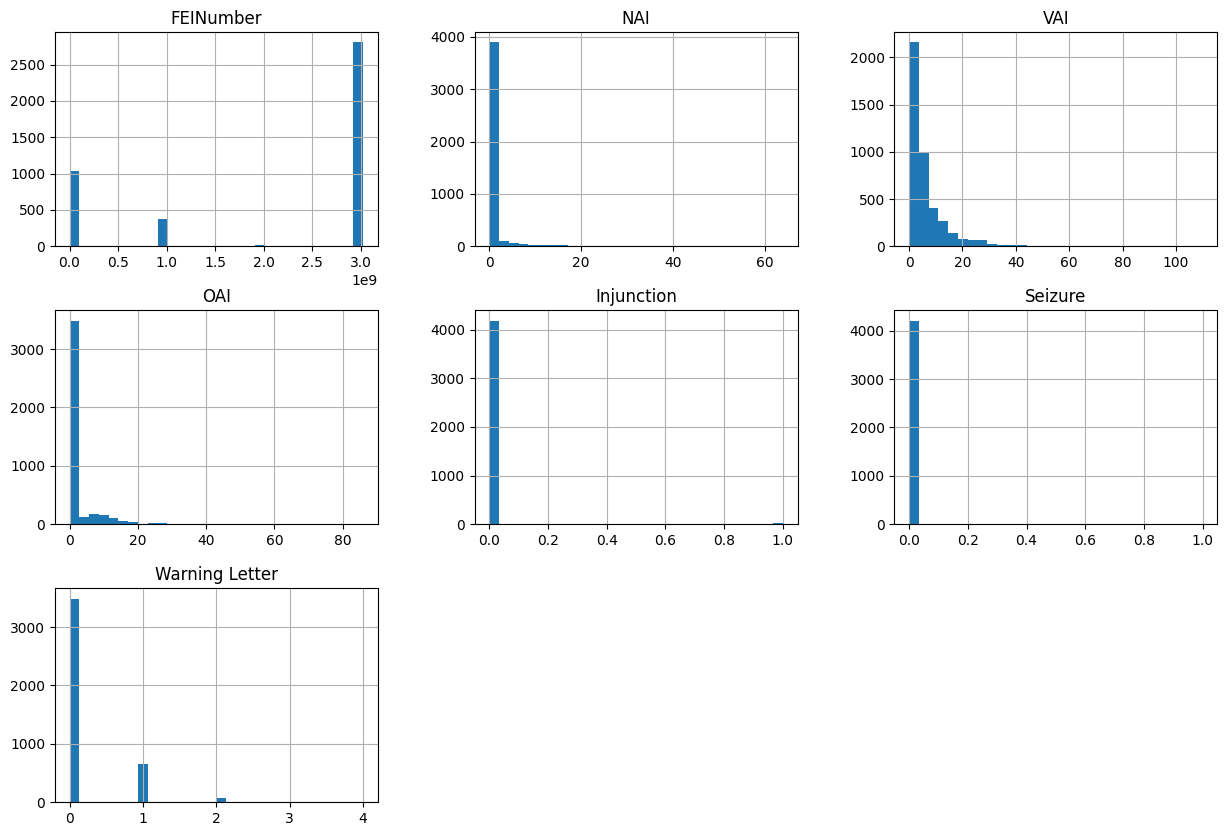

In [45]:
#looking at the distribution of the data
M1.hist(bins=30, figsize=(15,10))

In [46]:
M1['Warning Letter'].value_counts()
#may need dummy








/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Warning Letter
0.0    3487
1.0     659
2.0      66
3.0       8
4.0       1
Name: count, dtype: int64

In [47]:
M1['Seizure'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Seizure
0.0    4210
1.0      11
Name: count, dtype: int64

In [48]:
M1['Injunction'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Injunction
0.0    4188
1.0      33
Name: count, dtype: int64

In [49]:
#M1['OAI'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
#M1['VAI'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
#M1['NAI'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
#M1['FEINumber'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
M1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FEINumber                                          LegalName  NAI  VAI  \
0            405                             Baxter Healthcare S.A.    0    7   
1           1196                                 Italfarmaco S.p.A.    0    4   
2           1379  Dynamit Nobel GmbH Explosivstoff- und Systemte...    0    3   
3        1010294                                     Old 97 Company    0   21   
4        1010370                                       USpharma Ltd    0    5   
...          ...                                                ...  ...  ...   
4216  3021451094  Purformance Wellness Pharmacy LLC dba Seven Cells    0    2   
4217  3021784212                         PRIME MATTER LABS WEST LLC    0    3   
4218  3021934346  Valor Compounding Pharmacy, Inc DBA  Valor Com...    0    1   
4219  3022352136                     BrittonField Laboratories Inc.    0    2   
4220  3023533273                     Sure-Biochem Laboratories, LLC    0    0   

      OAI  Injunction  Seizure  Warning Letter  RecallC1orC2  
0       0         0.0      0.0             0.0         False  
1       0         0.0      0.0             0.0         False  
2       0         0.0      0.0             0.0         False  
3       0         0.0      0.0             0.0         False  
4       0         0.0      0.0             0.0         False  
...   ...         ...      ...             ...           ...  
4216    0         0.0      0.0             0.0         False  
4217    0         0.0      0.0             0.0         False  
4218    0         0.0      0.0             0.0          True  
4219    0         0.0      0.0             0.0         False  
4220    6         0.0      0.0             1.0         False  

[4221 rows x 9 columns]

In [54]:
#Dummy Code is not needed

#dummy_data = pd.get_dummies(M1[['Warning Letter']].astype(str),drop_first=True)
#dummy_data = dummy_data.astype(int)
#dummy_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# combining the dummy coded categorical and the num variables
#M1_Copy= M1.copy()
#M1_Copy.drop("Warning Letter", inplace=True, axis='columns')
#M1_Copy.drop("LegalName", inplace=True, axis='columns')
#num_names= M1_Copy
#X = pd.concat([num_names,dummy_data],axis=1)
#X.describe(include='all').T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
X = M1.copy()
#non numeric or categorical data
X.drop("LegalName", inplace=True, axis='columns')
X.drop("FEINumber", inplace=True, axis='columns')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
#checking the skewness of the variables
X.skew(axis=0,skipna=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NAI                6.955498
VAI                3.505379
OAI                4.570202
Injunction        11.180600
Seizure           19.519238
Warning Letter     2.456646
RecallC1orC2       2.397854
dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[<Axes: title={'center': 'NAI'}>, <Axes: title={'center': 'VAI'}>],
       [<Axes: title={'center': 'OAI'}>,
        <Axes: title={'center': 'Injunction'}>],
       [<Axes: title={'center': 'Seizure'}>,
        <Axes: title={'center': 'Warning Letter'}>]], dtype=object)

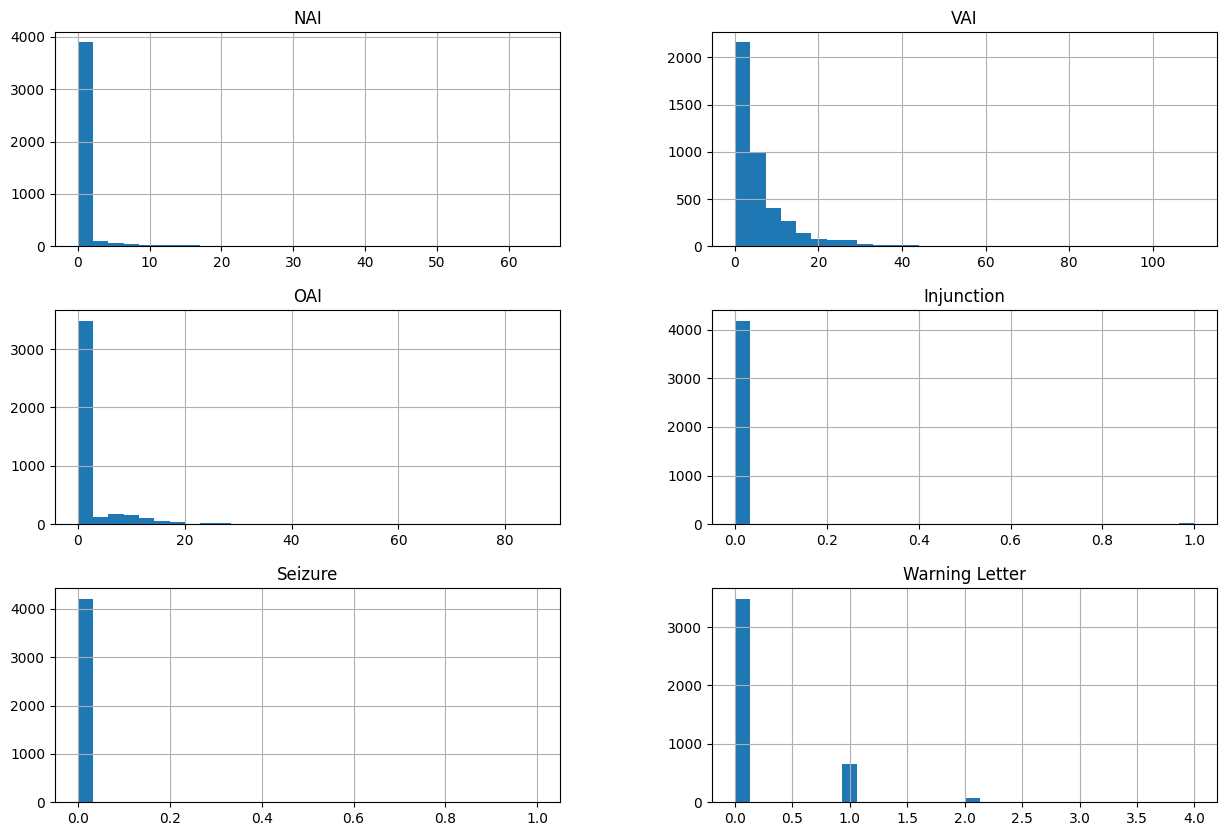

In [58]:
# visually checking the skewness of the variables
X.hist(bins=30, figsize=(15,10))

In [59]:
#dropping the output variable so it isnt included in the logit model
X.drop("RecallC1orC2", inplace=True, axis='columns')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:

# Checking for Multicolinearity in Data using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['features']=X.columns

vif_data['VIF']=[variance_inflation_factor(X.values,i)
                      for i in range(len(X.columns))]

print(vif_data)

         features       VIF
0             NAI  1.001310
1             VAI  1.088548
2             OAI  1.725038
3      Injunction  1.109113
4         Seizure  1.042190
5  Warning Letter  1.596862


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
#setting up y and constant to do logit
import statsmodels.api as sm
y=dfNL['RecallC1orC2']

X = sm.add_constant(X) # To use constant for the logistic regression models below.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
#looking at the variables left and making sure constant is added
X.info()
X.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   const           4221 non-null   float64
 1   NAI             4221 non-null   int64  
 2   VAI             4221 non-null   int64  
 3   OAI             4221 non-null   int64  
 4   Injunction      4221 non-null   float64
 5   Seizure         4221 non-null   float64
 6   Warning Letter  4221 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 231.0 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4221, 7)

In [63]:
# Spliting the data set into train and test sets

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y, stratify=y,
                                             test_size=0.3,
                                             random_state=0)
print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)
print(100*y_train.value_counts()/len(y_train))

(2954, 7) (1267, 7) (2954,) (1267,)
RecallC1orC2
False    88.388626
True     11.611374
Name: count, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
# Oversampling the data using SMOTE to deal with the imbalanced data
from imblearn.over_sampling import SMOTE
train_size = y_train.shape[0]
print("Initial training set size: ",train_size)
print("Initial test set size: ", y_test.shape[0])
print(f"There are {np.sum(y_train.values)} and {np.sum(y_test.values)} 1s"+
      " in the training set and the test set, respectively.")

X_train_over, y_train_over = SMOTE(sampling_strategy=1/1).fit_resample(X_train, y_train)
nPos = np.sum(y_train_over.values)
nTrain = np.sum(y_train_over.shape[0])
perc_positive = nPos*100/nTrain

print(f"There are {perc_positive}% ({nPos} out of {nTrain}) 1s in the training data after SMOTE")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated a

Initial training set size:  2954
Initial test set size:  1267
There are 343 and 147 1s in the training set and the test set, respectively.
There are 50.0% (2611 out of 5222) 1s in the training data after SMOTE


In [65]:
# Training a Logit model over the oversampled training set

log_reg = sm.Logit(y_train_over,X_train_over).fit()
print(log_reg.summary())

         Current function value: 0.560222
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           RecallC1orC2   No. Observations:                 5222
Model:                          Logit   Df Residuals:                     5215
Method:                           MLE   Df Model:                            6
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                  0.1918
Time:                        17:52:06   Log-Likelihood:                -2925.5
converged:                      False   LL-Null:                       -3619.6
Covariance Type:            nonrobust   LLR p-value:                8.385e-297
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7885      0.049    -16.252      0.000      -0.884      -0.693
NAI               -0.3920      0.060     -6.582      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [66]:
# Drop the variable with the highest p-value and rerun the model.
# If all the variables are significant, then no need to refine the model.
# Here we automate the process by defining backward_elimination function

def backward_elimination(data, target, significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features) > 0):
        features_with_constant = sm.add_constant(data[features]) # adding a constant (intercept) to the model
        stepwise_reg = sm.Logit(target, features_with_constant).fit(disp=False) # fitting the model
        p_values = stepwise_reg.pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return stepwise_reg, features

# Call the backward elimination function
result = backward_elimination(X_train_over, y_train_over)
final_model = result[0]
feature_list = result[1]
print('The resulting features are :', feature_list)
print(final_model.summary())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The resulting features are : ['const', 'NAI', 'VAI', 'OAI', 'Injunction', 'Warning Letter']
                           Logit Regression Results                           
Dep. Variable:           RecallC1orC2   No. Observations:                 5222
Model:                          Logit   Df Residuals:                     5216
Method:                           MLE   Df Model:                            5
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                  0.1907
Time:                        17:52:07   Log-Likelihood:                -2929.5
converged:                       True   LL-Null:                       -3619.6
Covariance Type:            nonrobust   LLR p-value:                2.654e-296
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7883      0.048    -16.349      0.000      -0.883      -0.694
NAI               -0.4008  

In [67]:
#model converged after dropping Seziure

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
from sklearn.metrics import confusion_matrix
prediction_prob = final_model.predict(X_test[feature_list])
# Use the threshold values different than 0.5 if necessary
threshold = 0.5

# Apply threshold to positive probabilities to create labels
prediction = (prediction_prob >= threshold).astype(int)
#print(prediction)

# Print confusion matrix
print(confusion_matrix(y_test, prediction))

[[942 178]
 [ 63  84]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

In [69]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1 = f1_score(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)

# Print the metrics for logistic
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

F1 Score:  0.4107579462102689
Accuracy:  0.8097868981846882
Precision:  0.32061068702290074
Recall:  0.5714285714285714


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

In [70]:
# calculation the Logistic ROC AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

lr_auc = roc_auc_score(y_test,prediction_prob)
print('Logistic: ROC AUC=%.3f' % (lr_auc))

Logistic: ROC AUC=0.776


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


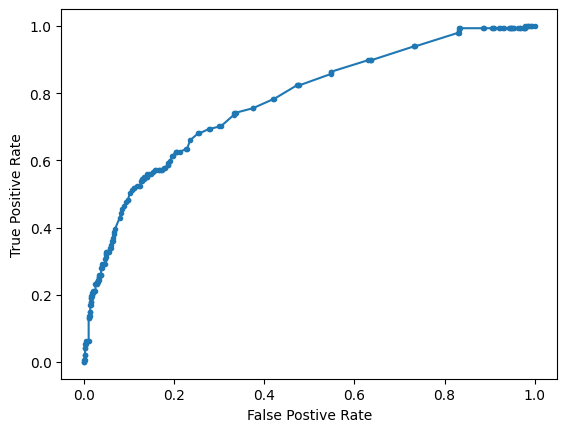

In [71]:
#plotting the ROC Curve
lr_fpr, lr_tpr, thr = roc_curve(y_test,prediction_prob)

plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[2225  386]
 [1005 1606]]
              precision    recall  f1-score   support

       False       0.69      0.85      0.76      2611
        True       0.81      0.62      0.70      2611

    accuracy                           0.73      5222
   macro avg       0.75      0.73      0.73      5222
weighted avg       0.75      0.73      0.73      5222

ROC_AUC:  0.77591659538989
[[942 178]
 [ 63  84]]
              precision    recall  f1-score   support

       False       0.94      0.84      0.89      1120
        True       0.32      0.57      0.41       147

    accuracy                           0.81      1267
   macro avg       0.63      0.71      0.65      1267
weighted avg       0.87      0.81      0.83      1267

ROC_AUC:  0.7762178085519923


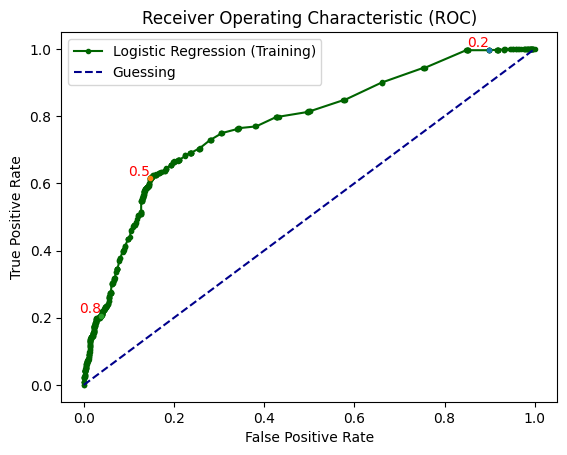

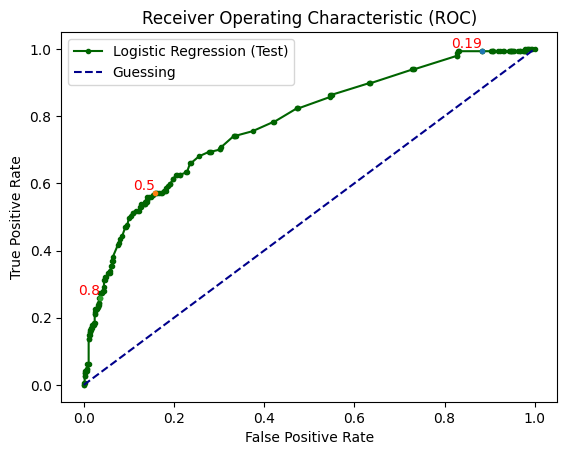

In [72]:
# Cross validation for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Too many warnings, so ignore them
import warnings
warnings.filterwarnings('ignore')


# Create a logistic regression object
logreg = LogisticRegression()


# Fit the model
logreg.fit(X_train_over, y_train_over)

# Predict the response values for the observations in X_train
lr_pred = logreg.predict(X_train_over)
# Predict the response values for the observations in X_test
lr_pred_test = logreg.predict(X_test)
# Predict the probability of response values for the observations in X_train
lr_pred_prob = logreg.predict_proba(X_train_over)[:,1]
# Predict the probability of response values for the observations in X_test
lr_pred_prob_test = logreg.predict_proba(X_test)[:,1]

# Display the confusion matrix, accuracy, precision, recall, F1 score, and roc_auc_score
display_metrics(y_train_over, lr_pred, lr_pred_prob)
display_metrics(y_test, lr_pred_test, lr_pred_prob_test)

# Draw the ROC curves for both the training and test data
draw_roc_curve(y_train_over, lr_pred_prob, thresholds=[0.2,0.5, 0.8],
               color='darkgreen',
               show_thresholds=True,
               classifier_name='Logistic Regression (Training)')
draw_roc_curve(y_test, lr_pred_prob_test, thresholds=[0.2,0.5, 0.8],
                color='darkgreen',
                show_thresholds=True,
                classifier_name='Logistic Regression (Test)')

# Model 1 DTree

In [73]:
# X_train_over and X_test contains const, which should not be used for Decision Tree
X_train_over.drop(['const'], axis='columns', inplace=True)
X_test.drop(['const'], axis='columns', inplace=True)

In [74]:
X_train_over.columns.values

array(['NAI', 'VAI', 'OAI', 'Injunction', 'Seizure', 'Warning Letter'],
      dtype=object)

In [75]:
# Build a decision tree model

from sklearn import tree
from sklearn.tree import export_text
from matplotlib import pyplot as plt

dtree = tree.DecisionTreeClassifier(max_depth=4,min_samples_split=30)
dtree = dtree.fit(X_train_over, y_train_over)
# Display decision tree results
r = export_text(dtree, feature_names=list(X_train_over.columns.values))
print(r)

|--- Warning Letter <= 0.00
|   |--- VAI <= 0.50
|   |   |--- Injunction <= 0.11
|   |   |   |--- OAI <= 13.50
|   |   |   |   |--- class: False
|   |   |   |--- OAI >  13.50
|   |   |   |   |--- class: False
|   |   |--- Injunction >  0.11
|   |   |   |--- class: True
|   |--- VAI >  0.50
|   |   |--- VAI <= 8.50
|   |   |   |--- VAI <= 4.50
|   |   |   |   |--- class: False
|   |   |   |--- VAI >  4.50
|   |   |   |   |--- class: False
|   |   |--- VAI >  8.50
|   |   |   |--- Injunction <= 0.02
|   |   |   |   |--- class: False
|   |   |   |--- Injunction >  0.02
|   |   |   |   |--- class: True
|--- Warning Letter >  0.00
|   |--- Warning Letter <= 1.00
|   |   |--- class: True
|   |--- Warning Letter >  1.00
|   |   |--- Warning Letter <= 1.00
|   |   |   |--- VAI <= 0.50
|   |   |   |   |--- class: True
|   |   |   |--- VAI >  0.50
|   |   |   |   |--- class: True
|   |   |--- Warning Letter >  1.00
|   |   |   |--- Warning Letter <= 1.99
|   |   |   |   |--- class: True
|   |   

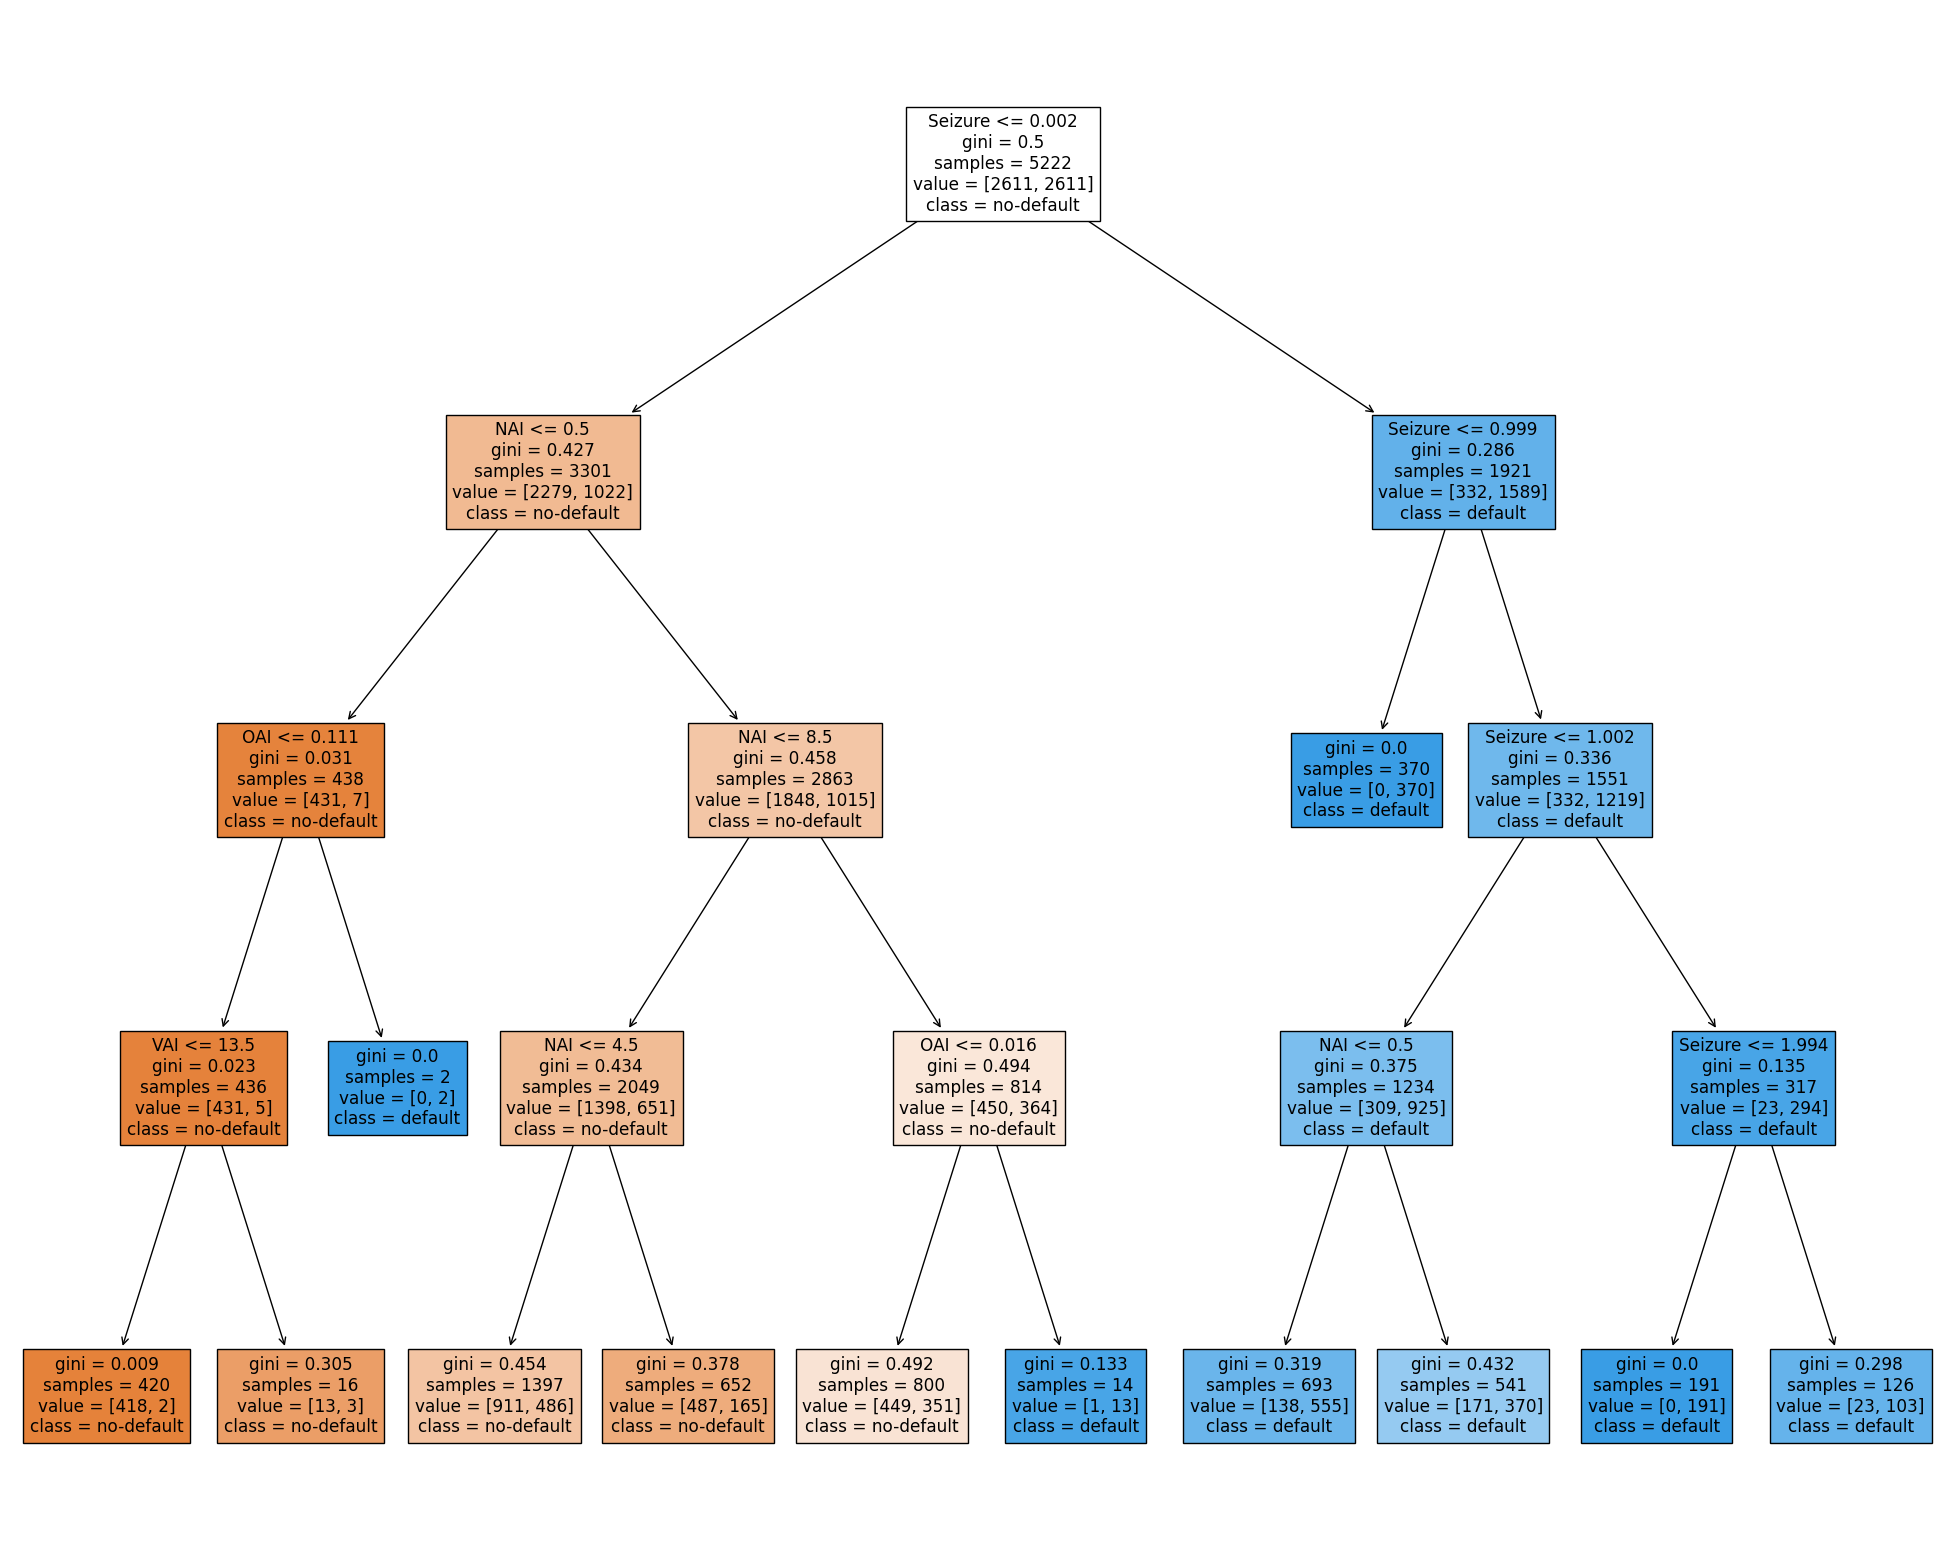

In [76]:
#plotting the descision tree
plt.figure(figsize=[25,20])
tree.plot_tree(dtree,
               feature_names=list(X_train.columns.values),
               class_names=['no-default', 'default'],
               filled=True)
plt.show()

In [77]:
# threshold for the Decision Tree model?
dtree_probs = dtree.predict_proba(X_test)
#custom threshold
threshold = 0.5

# Convert probabilities into classes
prediction_tree = (dtree_probs[:, 1] >= threshold).astype('int')

In [78]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1 = f1_score(y_test, prediction_tree)
accuracy = accuracy_score(y_test, prediction_tree)
precision = precision_score(y_test, prediction_tree)
recall = recall_score(y_test, prediction_tree)

# Print the metrics for dtree
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

F1 Score:  0.4153005464480874
Accuracy:  0.8310970797158642
Precision:  0.3470319634703196
Recall:  0.5170068027210885


Decision Tree: ROC AUC=0.750


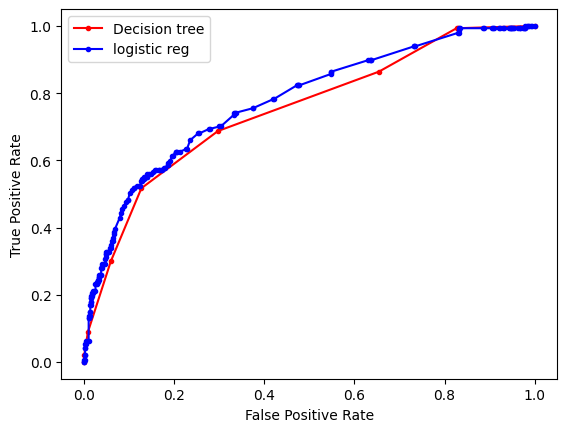

In [79]:
#Evaluation model performance using the validation dataset
from sklearn.metrics import confusion_matrix
#Criteria 1: the confusion matrix
#prediction =dtree.predict(X_test)
confusion_matrix(y_test,prediction)
dtree.score(X_test,y_test)
#Criteria 2: the ROC curve and area under the curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
prediction_prob = dtree.predict_proba(X_test)
# calculate AUC scores
# only keeps the probabilities of one class, since tree models can be used for
# multi label classifications
tree_auc = roc_auc_score(y_test, prediction_prob[:,1])
print('Decision Tree: ROC AUC=%.3f' % (tree_auc))
# calculate roc curves
tree_fpr, tree_tpr, _ = roc_curve(y_test, prediction_prob[:,1])
# plot the roc curve for the model
plt.plot(tree_fpr, tree_tpr, marker='.', color ='red', label = 'Decision tree')
#plot for roc logistic regression
plt.plot(lr_fpr, lr_tpr, marker='.', color = 'blue', label = 'logistic reg')
plt.legend()
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

In [80]:
# Use Decision Tree in the sklearn module.
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier object
# I suggest you fine tune the value of max_depth and min_samples_leaf (GridSearchDV may be used)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2, random_state=0)

# Fit the decision tree classifier
# There are still constant values in the training data and test data, but it does not matter for decision trees
dt.fit(X_train_over, y_train_over)
dt_pred_train = dt.predict(X_train_over)
dt_pred_test = dt.predict(X_test)
dt_pred_train_prob = dt.predict_proba(X_train_over)[:,1]
dt_pred_test_prob = dt.predict_proba(X_test)[:,1]

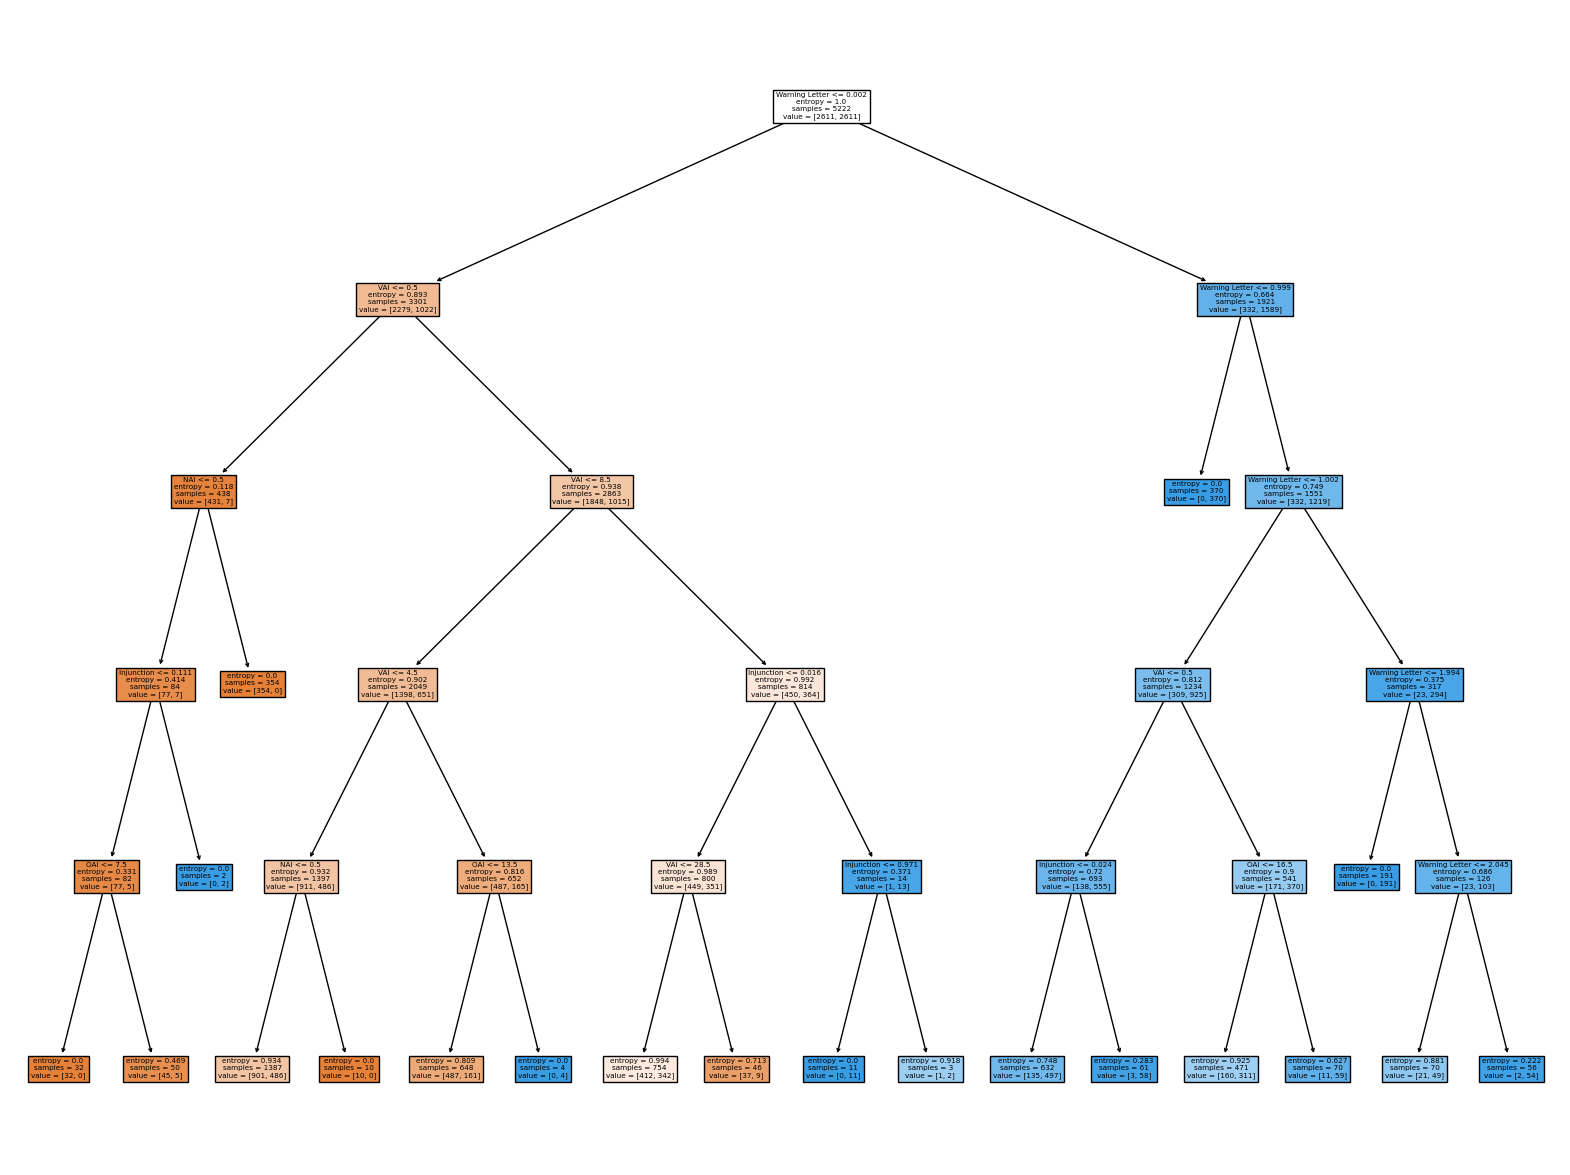

In [81]:
# Show the decision tree
from sklearn import tree
plt.figure(figsize=(20,15))
tree.plot_tree(dt,feature_names=list(X_train_over.columns.values), filled=True)
plt.show()

In [82]:
# Performance evaluation
display_metrics(y_train_over, dt_pred_train, dt_pred_train_prob)
display_metrics(y_test, dt_pred_test, dt_pred_test_prob)

[[2278  333]
 [1003 1608]]
              precision    recall  f1-score   support

       False       0.69      0.87      0.77      2611
        True       0.83      0.62      0.71      2611

    accuracy                           0.74      5222
   macro avg       0.76      0.74      0.74      5222
weighted avg       0.76      0.74      0.74      5222

ROC_AUC:  0.8196939824309285
[[977 143]
 [ 70  77]]
              precision    recall  f1-score   support

       False       0.93      0.87      0.90      1120
        True       0.35      0.52      0.42       147

    accuracy                           0.83      1267
   macro avg       0.64      0.70      0.66      1267
weighted avg       0.87      0.83      0.85      1267

ROC_AUC:  0.7435343780369291


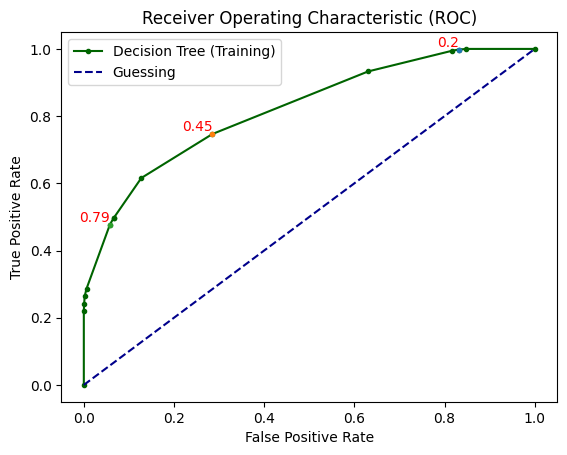

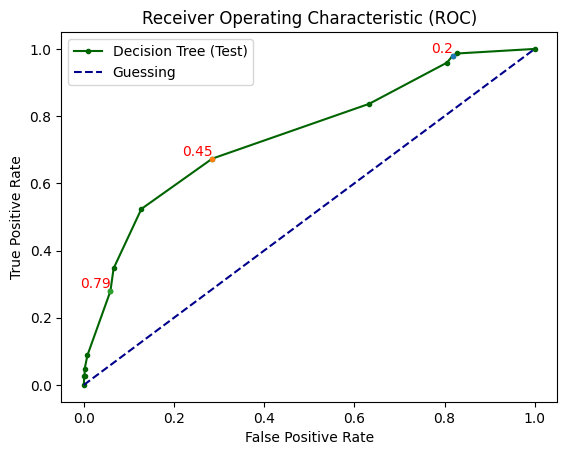

In [83]:
# Draw the ROC curves for both the training and test data
draw_roc_curve(y_train_over, dt_pred_train_prob, thresholds=[0.2,0.5, 0.8],
               color='darkgreen',
               show_thresholds=True,
               classifier_name='Decision Tree (Training)')
draw_roc_curve(y_test, dt_pred_test_prob, thresholds=[0.2,0.5, 0.8],
               color='darkgreen',
               show_thresholds=True,
               classifier_name='Decision Tree (Test)')

# Model 2 Logistic Regression

In [84]:
M2 =dfNL.copy()

In [85]:
M2

FEINumber                                          LegalName  \
0            405                             Baxter Healthcare S.A.   
1           1196                                 Italfarmaco S.p.A.   
2           1379  Dynamit Nobel GmbH Explosivstoff- und Systemte...   
3        1010294                                     Old 97 Company   
4        1010370                                       USpharma Ltd   
...          ...                                                ...   
4216  3021451094  Purformance Wellness Pharmacy LLC dba Seven Cells   
4217  3021784212                         PRIME MATTER LABS WEST LLC   
4218  3021934346  Valor Compounding Pharmacy, Inc DBA  Valor Com...   
4219  3022352136                     BrittonField Laboratories Inc.   
4220  3023533273                     Sure-Biochem Laboratories, LLC   

                                       ShortDescription  \
0     Control procedures to monitor and validate per...   
1     Manufacturing Instructions and Specifications;...   
2     Investigations of discrepancies, failures; Wri...   
3     No written record of investigation; Scientific...   
4     Representative Samples; Establish reliability ...   
...                                                 ...   
4216  Non-microbial contamination, production area; ...   
4217  Calibration/Inspection/Checking not done; Inve...   
4218  Hazardous drugs, prevention of cross-contamina...   
4219  Test methods; Written procedures not establish...   
4220  Lack of quality control unit; Following/docume...   

                                        LongDescription  NAI  VAI  OAI  \
0     Control procedures are not established which m...    0    7    0   
1     The master production and control records are ...    0    4    0   
2     There is a failure to thoroughly review any un...    0    3    0   
3     Written records are not made of investigations...    0   21    0   
4     Representative samples are not taken of each s...    0    5    0   
...                                                 ...  ...  ...  ...   
4216  Non-microbial contamination was observed in yo...    0    2    0   
4217  Routine calibration of electronic equipment is...    0    3    0   
4218  You produced hazardous drugs without providing...    0    1    0   
4219  The accuracy, sensitivity, specificity and rep...    0    2    0   
4220  There is no quality control unit.; Established...    0    0    6   

      Injunction  Seizure  Warning Letter  RecallC1orC2  \
0            0.0      0.0             0.0         False   
1            0.0      0.0             0.0         False   
2            0.0      0.0             0.0         False   
3            0.0      0.0             0.0         False   
4            0.0      0.0             0.0         False   
...          ...      ...             ...           ...   
4216         0.0      0.0             0.0         False   
4217         0.0      0.0             0.0         False   
4218         0.0      0.0             0.0          True   
4219         0.0      0.0             0.0         False   
4220         0.0      0.0             1.0         False   

                                           Cleaned Text  \
0     control procedure monitor validate performance...   
1     manufacturing instruction specification stabil...   
2     investigation discrepancy failure written proc...   
3     no written record investigation scientifically...   
4     representative sample establish reliability su...   
...                                                 ...   
4216  nonmicrobial contamination production area haz...   
4217  calibrationinspectionchecking done investigati...   
4218       hazardous drug prevention crosscontamination   
4219  test method written procedure establishedfollowed   
4220  lack quality control unit followingdocumenting...   

                                      Cleaned Text Long  
0     control procedure established monitor output m...  
1     the master produ

In [86]:
# Apply tf-idf to adjust weights of the Document_Term_Matrix
tfidf = models.TfidfModel(DFM_L)
DFM_tfidf = tfidf[DFM_L]

In [87]:
# Apply SVD and keep 5 dimensions
# https://radimrehurek.com/gensim/models/lsimodel.html
n_SVD = 5
SVD_model = models.LsiModel(DFM_tfidf,id2word=dictionary_L, num_topics=n_SVD)
SVD=SVD_model[DFM_tfidf]

In [88]:
# Convert the results into Array
import gensim
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()
# Convert the results into data frame
svd_df = pd.DataFrame(svd_array)
# Show SVD results: reduced vector representation of the text documents svd_df
svd_df

0         1         2         3         4
0     0.425934 -0.026438  0.031018 -0.169430 -0.209410
1     0.223882 -0.045896  0.151223  0.047808 -0.031460
2     0.306807 -0.055596  0.332318 -0.107556 -0.203296
3     0.493353 -0.105044 -0.190598 -0.028976  0.023456
4     0.345465 -0.032861 -0.067973 -0.210192 -0.193654
...        ...       ...       ...       ...       ...
4216  0.081567  0.095791 -0.016131  0.017913  0.041645
4217  0.356246 -0.018935 -0.053126 -0.164408 -0.249054
4218  0.037322  0.037321 -0.023687  0.001285  0.025948
4219  0.242677 -0.002465 -0.015608  0.041937 -0.035899
4220  0.366612  0.073574 -0.015497  0.013570 -0.162294

[4221 rows x 5 columns]

In [89]:
# Change the column names to be more meaningful
svd_df.columns = ['SVD_'+str(i) for i in range(n_SVD)]
svd_df.columns

Index(['SVD_0', 'SVD_1', 'SVD_2', 'SVD_3', 'SVD_4'], dtype='object')

In [90]:
non_text_df = M2

In [91]:

non_text_df.drop("LegalName", inplace=True, axis='columns')
non_text_df.drop("FEINumber", inplace=True, axis='columns')
non_text_df.drop("Cleaned Text", inplace=True, axis='columns')
non_text_df.drop("Cleaned Text Long", inplace=True, axis='columns')
non_text_df.drop("ShortDescription", inplace=True, axis='columns')
non_text_df.drop("LongDescription", inplace=True, axis='columns')

In [92]:
non_text_df

NAI  VAI  OAI  Injunction  Seizure  Warning Letter  RecallC1orC2
0       0    7    0         0.0      0.0             0.0         False
1       0    4    0         0.0      0.0             0.0         False
2       0    3    0         0.0      0.0             0.0         False
3       0   21    0         0.0      0.0             0.0         False
4       0    5    0         0.0      0.0             0.0         False
...   ...  ...  ...         ...      ...             ...           ...
4216    0    2    0         0.0      0.0             0.0         False
4217    0    3    0         0.0      0.0             0.0         False
4218    0    1    0         0.0      0.0             0.0          True
4219    0    2    0         0.0      0.0             0.0         False
4220    0    0    6         0.0      0.0             1.0         False

[4221 rows x 7 columns]

In [93]:
svd_df

SVD_0     SVD_1     SVD_2     SVD_3     SVD_4
0     0.425934 -0.026438  0.031018 -0.169430 -0.209410
1     0.223882 -0.045896  0.151223  0.047808 -0.031460
2     0.306807 -0.055596  0.332318 -0.107556 -0.203296
3     0.493353 -0.105044 -0.190598 -0.028976  0.023456
4     0.345465 -0.032861 -0.067973 -0.210192 -0.193654
...        ...       ...       ...       ...       ...
4216  0.081567  0.095791 -0.016131  0.017913  0.041645
4217  0.356246 -0.018935 -0.053126 -0.164408 -0.249054
4218  0.037322  0.037321 -0.023687  0.001285  0.025948
4219  0.242677 -0.002465 -0.015608  0.041937 -0.035899
4220  0.366612  0.073574 -0.015497  0.013570 -0.162294

[4221 rows x 5 columns]

In [94]:
model_df = pd.concat([non_text_df, svd_df],axis = 1)
model_df

NAI  VAI  OAI  Injunction  Seizure  Warning Letter  RecallC1orC2  \
0       0    7    0         0.0      0.0             0.0         False   
1       0    4    0         0.0      0.0             0.0         False   
2       0    3    0         0.0      0.0             0.0         False   
3       0   21    0         0.0      0.0             0.0         False   
4       0    5    0         0.0      0.0             0.0         False   
...   ...  ...  ...         ...      ...             ...           ...   
4216    0    2    0         0.0      0.0             0.0         False   
4217    0    3    0         0.0      0.0             0.0         False   
4218    0    1    0         0.0      0.0             0.0          True   
4219    0    2    0         0.0      0.0             0.0         False   
4220    0    0    6         0.0      0.0             1.0         False   

         SVD_0     SVD_1     SVD_2     SVD_3     SVD_4  
0     0.425934 -0.026438  0.031018 -0.169430 -0.209410  
1     0.223882 -0.045896  0.151223  0.047808 -0.031460  
2     0.306807 -0.055596  0.332318 -0.107556 -0.203296  
3     0.493353 -0.105044 -0.190598 -0.028976  0.023456  
4     0.345465 -0.032861 -0.067973 -0.210192 -0.193654  
...        ...       ...       ...       ...       ...  
4216  0.081567  0.095791 -0.016131  0.017913  0.041645  
4217  0.356246 -0.018935 -0.053126 -0.164408 -0.249054  
4218  0.037322  0.037321 -0.023687  0.001285  0.025948  
4219  0.242677 -0.002465 -0.015608  0.041937 -0.035899  
4220  0.366612  0.073574 -0.015497  0.013570 -0.162294  

[4221 rows x 12 columns]

In [95]:
# Including SVD columns
X2 = model_df.drop(['RecallC1orC2'],axis=1)
y2 = model_df[['RecallC1orC2']]
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,stratify=y2,
                                             test_size=0.3,
                                             random_state=0)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((2954, 11), (1267, 11), (2954, 1), (1267, 1))

In [96]:
# Oversampling the data using SMOTE to deal with the imbalanced data
from imblearn.over_sampling import SMOTE
train_size = y2_train.shape[0]
print("Initial training set size: ",train_size)
print("Initial test set size: ", y2_test.shape[0])
print(f"There are {np.sum(y2_train.values)} and {np.sum(y2_test.values)} 1s"+
      " in the training set and the test set, respectively.")

X2_train_over, y2_train_over = SMOTE(sampling_strategy=1/1).fit_resample(X2_train, y2_train)
nPos = np.sum(y2_train_over.values)
nTrain = np.sum(y2_train_over.shape[0])
perc_positive = nPos*100/nTrain

print(f"There are {perc_positive}% ({nPos} out of {nTrain}) 1s in the training data after SMOTE")

Initial training set size:  2954
Initial test set size:  1267
There are 343 and 147 1s in the training set and the test set, respectively.
There are 50.0% (2611 out of 5222) 1s in the training data after SMOTE


In [97]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Too many warnings, so ignore them
import warnings
warnings.filterwarnings('ignore')


# Create a logistic regression object
logreg2 = LogisticRegression()

# Add constant to the training data and test data
X2_train_over = sm.add_constant(X2_train_over)
X2_test = sm.add_constant(X2_test)

# Fit the model
logreg2.fit(X2_train_over, y2_train_over)

# Predict the response values for the observations in X2_train
lr2_pred_train = logreg2.predict(X2_train_over)
# Predict the response values for the observations in X2_test
lr2_pred_test = logreg2.predict(X2_test)
# Predict the probability of response values for the observations in X2_train
lr2_pred_prob_train = logreg2.predict_proba(X2_train_over)[:,1]
# Predict the probability of response values for the observations in X2_test
lr2_pred_prob_test = logreg2.predict_proba(X2_test)[:,1]

[[2073  538]
 [ 783 1828]]
              precision    recall  f1-score   support

       False       0.73      0.79      0.76      2611
        True       0.77      0.70      0.73      2611

    accuracy                           0.75      5222
   macro avg       0.75      0.75      0.75      5222
weighted avg       0.75      0.75      0.75      5222

ROC_AUC:  0.8309710662003447
[[890 230]
 [ 39 108]]
              precision    recall  f1-score   support

       False       0.96      0.79      0.87      1120
        True       0.32      0.73      0.45       147

    accuracy                           0.79      1267
   macro avg       0.64      0.76      0.66      1267
weighted avg       0.88      0.79      0.82      1267

ROC_AUC:  0.8443786443148689


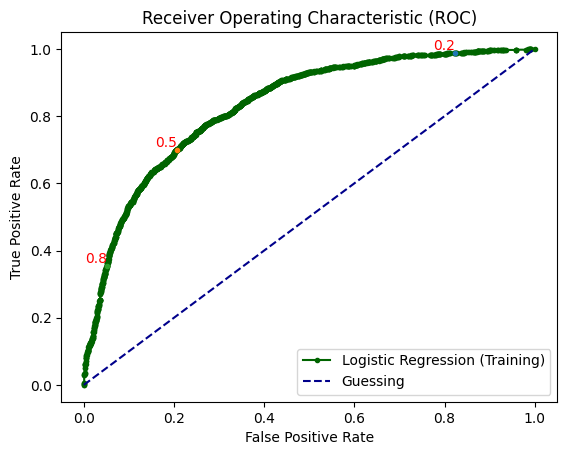

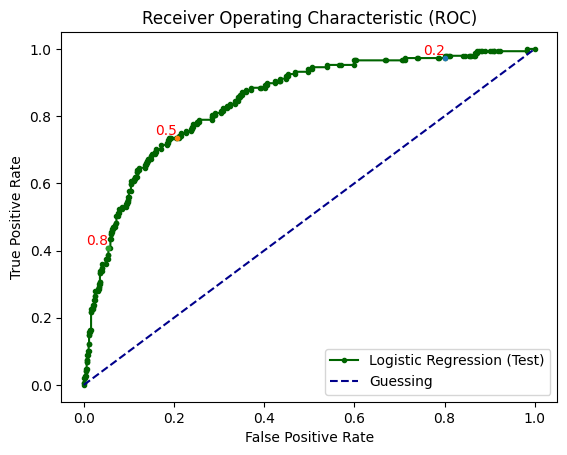

In [98]:
# Display the confusion matrix, accuracy, precision, recall, F1 score, and roc_auc_score
display_metrics(y2_train_over, lr2_pred_train, lr2_pred_prob_train)
display_metrics(y2_test, lr2_pred_test, lr2_pred_prob_test)

# Draw the ROC curves for both the training and test data
draw_roc_curve(y2_train_over, lr2_pred_prob_train, thresholds=[0.2,0.5, 0.8],
               color='darkgreen',
               show_thresholds=True,
               classifier_name='Logistic Regression (Training)')
draw_roc_curve(y2_test, lr2_pred_prob_test, thresholds=[0.2,0.5, 0.8],
                color='darkgreen',
                show_thresholds=True,
                classifier_name='Logistic Regression (Test)')



# Model 2 DTree

In [99]:
# Use Decision Tree in the sklearn module.
from sklearn.tree import DecisionTreeClassifier

dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2, random_state=0)

# Fit the decision tree classifier
# There are still constant values in the training data and test data, but it does not matter for decision trees
dt2.fit(X2_train_over, y2_train_over)
dt2_pred_train = dt2.predict(X2_train_over)
dt2_pred_test = dt2.predict(X2_test)
dt2_pred_train_prob = dt2.predict_proba(X2_train_over)[:,1]
dt2_pred_test_prob = dt2.predict_proba(X2_test)[:,1]

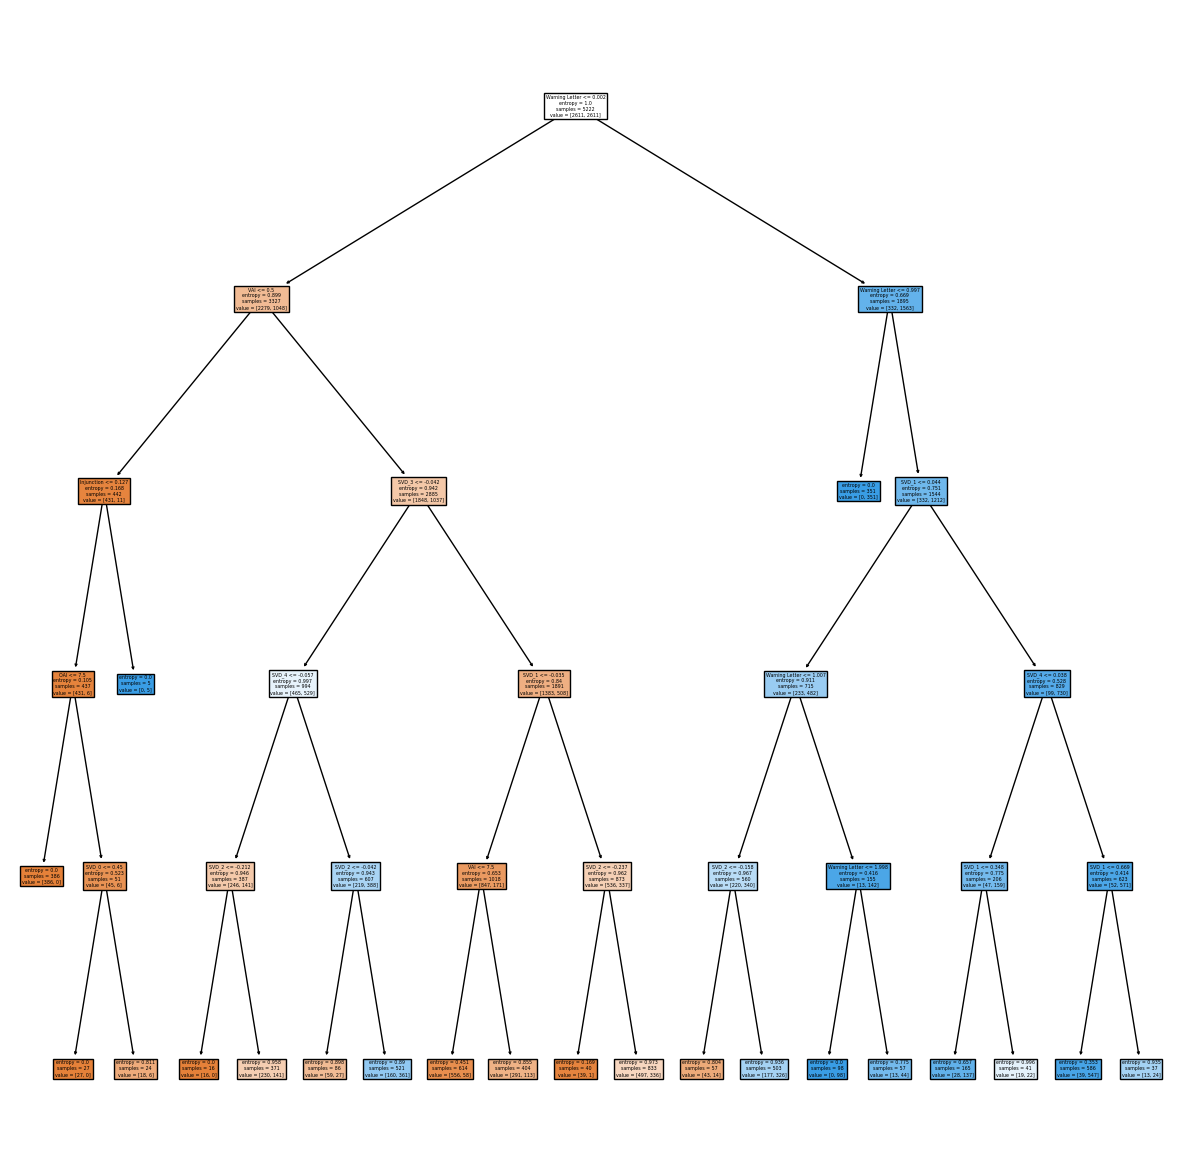

In [100]:
# Show the decision tree
from sklearn import tree
plt.figure(figsize=(15,15))
tree.plot_tree(dt2,feature_names=list(X2_train_over.columns.values), filled=True)
plt.show()

In [101]:
# Performance evaluation
display_metrics(y2_train_over, dt2_pred_train, dt2_pred_train_prob)
display_metrics(y2_test, dt2_pred_test, dt2_pred_test_prob)


[[2162  449]
 [ 696 1915]]
              precision    recall  f1-score   support

       False       0.76      0.83      0.79      2611
        True       0.81      0.73      0.77      2611

    accuracy                           0.78      5222
   macro avg       0.78      0.78      0.78      5222
weighted avg       0.78      0.78      0.78      5222

ROC_AUC:  0.8650788190845053
[[929 191]
 [ 52  95]]
              precision    recall  f1-score   support

       False       0.95      0.83      0.88      1120
        True       0.33      0.65      0.44       147

    accuracy                           0.81      1267
   macro avg       0.64      0.74      0.66      1267
weighted avg       0.88      0.81      0.83      1267

ROC_AUC:  0.806799684159378


In [102]:
y_train_over

0       False
1       False
2       False
3       False
4       False
        ...  
5217     True
5218     True
5219     True
5220     True
5221     True
Name: RecallC1orC2, Length: 5222, dtype: bool

In [103]:
y2_train_over

RecallC1orC2
0            False
1            False
2            False
3            False
4            False
...            ...
5217          True
5218          True
5219          True
5220          True
5221          True

[5222 rows x 1 columns]

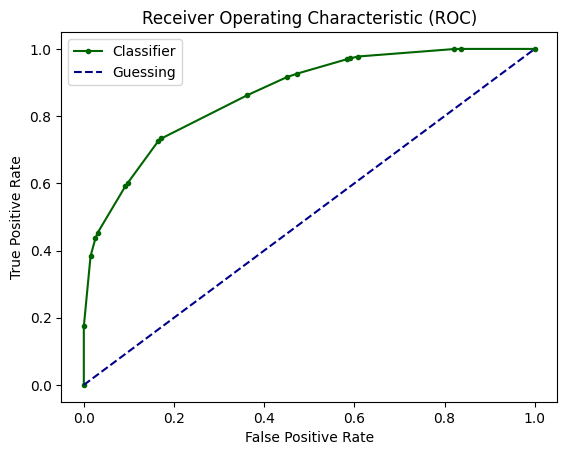

In [104]:
draw_roc_curve(y_train_over,dt2_pred_train_prob)

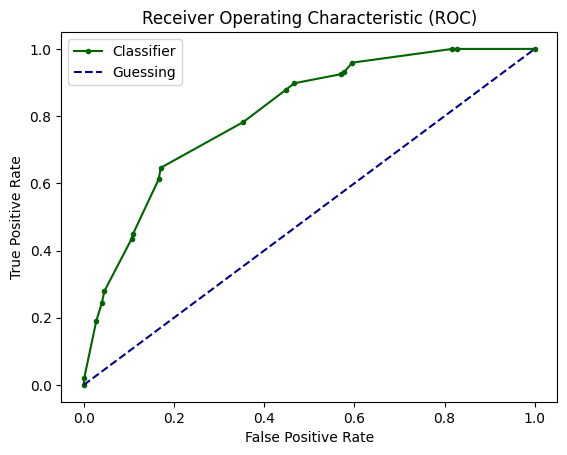

In [105]:
draw_roc_curve(y2_test,dt2_pred_test_prob)

# Comparing The Models


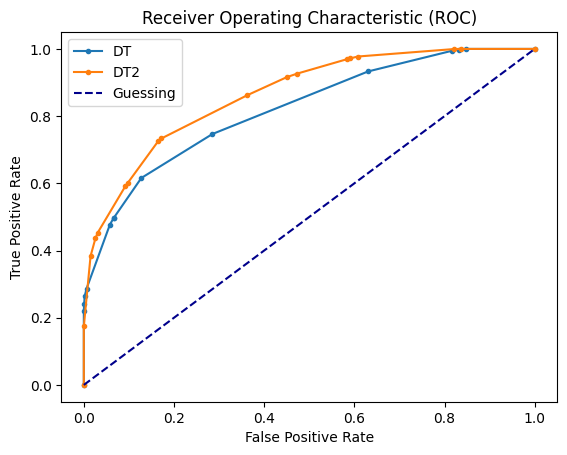

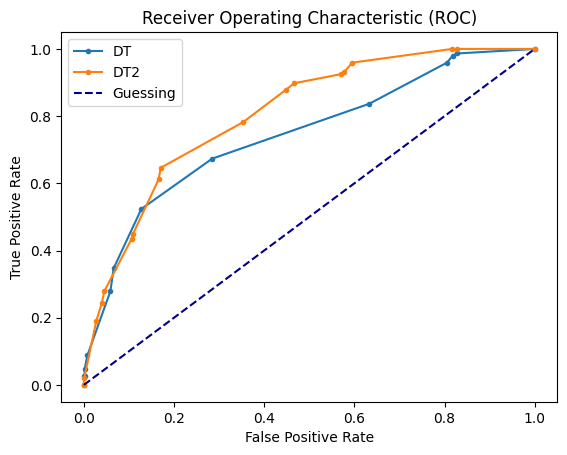

In [106]:
# Draw two ROC curves in a single plot
draw_roc_curves(y_train_over, [dt_pred_train_prob, dt2_pred_train_prob], ['DT', 'DT2'])
draw_roc_curves(y2_test, [dt_pred_test_prob, dt2_pred_test_prob], ['DT', 'DT2'])


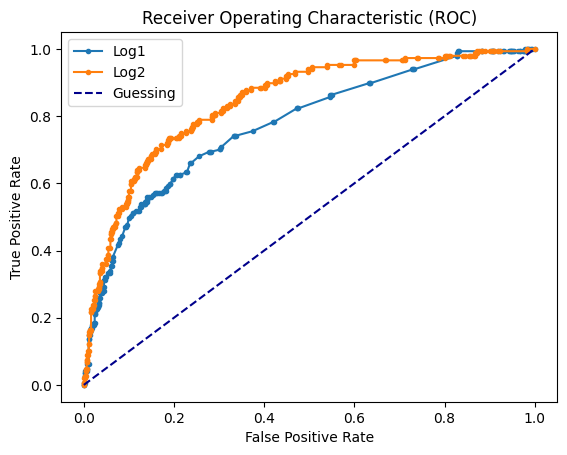

In [107]:
#Compare Logistic Performance Between M1 and M2
draw_roc_curves(y2_test, [lr_pred_prob_test,lr2_pred_prob_test], ['Log1','Log2'])

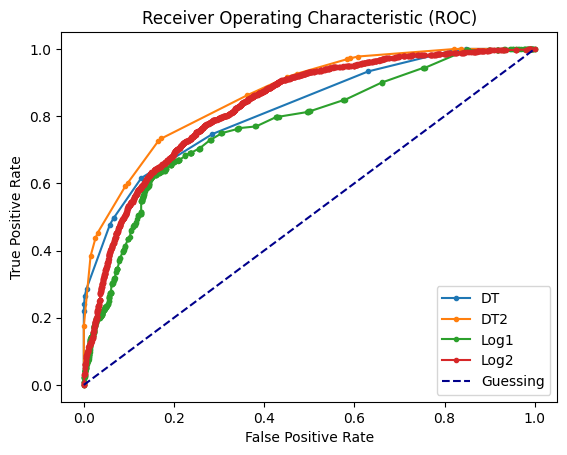

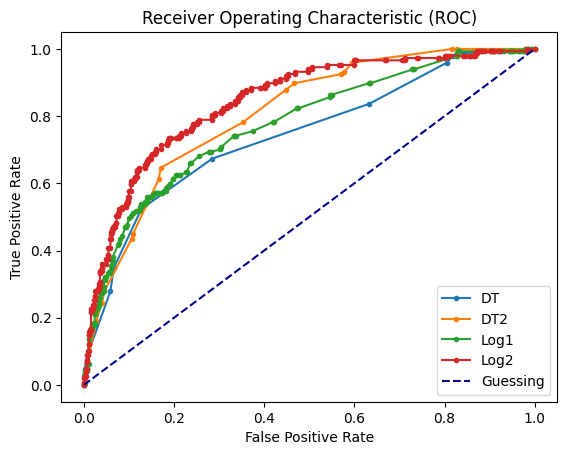

In [108]:
# Draw all four ROC curves in a single plot
draw_roc_curves(y_train_over, [dt_pred_train_prob, dt2_pred_train_prob,lr_pred_prob,lr2_pred_prob_train], ['DT', 'DT2','Log1','Log2'])
draw_roc_curves(y2_test, [dt_pred_test_prob, dt2_pred_test_prob,lr_pred_prob_test,lr2_pred_prob_test], ['DT', 'DT2','Log1','Log2'])